In [2]:
import sys
import os
import random
import string
import time
import pickle

import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda

2023-12-26 16:54:46.141367: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 16:54:46.291697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 16:54:46.291793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 16:54:46.297777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 16:54:46.323945: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 16:54:49.000685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

# Нейросеть на Tensorflow

## Подготовка данных

Я использую датасет разговоров людей с моделями отыгрывающими выдуманных персонажей на сайте character.ai .   
Ссылка на датасет: https://huggingface.co/datasets/PygmalionAI/PIPPA

Архитектура модели основана на вот этом репозитории:
https://github.com/Moeinh77/Chatbot-with-TensorFlow-and-Keras

Сначала загружем датасет и сформирем датафрэйм с парами вопрос-ответ на котором будет проводиться обучение.

In [4]:
data = pd.read_json("./pippa_deduped.jsonl", lines=True)

Можно взять датасет в целом, но я возьму только беседы с принцессой Селестией из мультсериала Мой Маленький Пони: 1) чтобы получить более интересного специализированного чатбота который будет притворяться принцессой Селестией и 2) потому что с ней есть подходящее количество данных.

In [5]:
data = data.loc[data["bot_name"] == "Celestia"]

In [6]:
train_conversations = data["conversation"]

In [55]:
print(f"Количество разговоров: {len(train_conversations)}")

Количество разговоров: 86


Теперь мы токенизируем текст, переводим в строчные буквы, очищаем от цифр, пунктуации и фрмируем в пары вопрос-ответ.

In [9]:
def grouper(iterable, n, incomplete='ignore', fillvalue=None):
    args = [iter(iterable)] * n
    if incomplete == 'fill':
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == 'strict':
        return _zip_equal(*args)
    if incomplete == 'ignore':
        return zip(*args)
    else:
        raise ValueError('Expected fill, strict, or ignore')

In [10]:
def text_clean(t):
    
    tokenized_text = [
        w for w in word_tokenize(t.lower())
        if w.isalpha()
    ]

    return " ".join(tokenized_text)

In [11]:
response_pairs = []
all_messages = []
start_token = '<startseq>'
end_token = '<endseq>'
for conversation in train_conversations:
    messages = [start_token + " " + text_clean(x["message"]) + " " + end_token for x in conversation]
    all_messages.extend(messages)
    response_pairs.extend(grouper(messages[1:], 2))

In [57]:
print(f"Количество пар вопрос-ответ: {len(response_pairs)}")

Количество пар вопрос-ответ: 1999


Так выглядят обработанные входные данные:

In [13]:
response_pairs[:5]

[('<startseq> you see a knight in black armor riding a fiery steed <endseq>',
  '<startseq> greetings celestia approaches the mysterious knight in black armor hello are you from griffonstone your appearance is very similar to many griffons i seen celestia looks up at the knight on his fiery steed oh my your horse is on fire are you alright if you need help i have the ability to move the sun i should be able to put your steed out celestia holds up a front hoof and starts charging her sun magic <endseq>'),
 ('<startseq> chuckles ha ha ha ha i am no griffon nor is this any steed but i sense your compassion and your power may i ask your name and titles if so i shall return the courtesy <endseq>',
  '<startseq> yes of course i am princess celestia of equestria and the sun some call me queen celestia and some call me the goddess celestia i am the of equestria alongside my younger sister the princess of the moon celestia takes a bow who might you be mysterious sir <endseq>'),
 ('<startseq> i 

Определяем оптимальную длинну входных данных для обучения, чтобы удалось уместить 80% текстов в датасете

In [14]:
def max_length(pairs,prct):
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)
    
    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))


max_len_q,max_len_a = max_length(response_pairs,80)

percentile 80 of len of questions: 39.0
longest sentence:  315

percentile 80 of len of answers: 81.0
longest sentence:  462

max-len questions for training:  39
max-len answers for training:  81


Создаем словарь в который включаются все слова встречающиеся более двух раз.

In [52]:
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    word_counts = {}
    nsents = 0
    for sent in all_messages:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    return vocab


short_vocab = create_reoccurring_vocab(response_pairs, word_count_threshold = 2)
# Удаляем односложные слова, кроме 'i', 'a'
for v in short_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        short_vocab.remove(v) 

In [50]:
vocab_len = len(short_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
print(f"Длина словаря: {vocab_len} слов")

Длина словаря: 4326 слов


Отсекаем пары которые содеражат редкие слова не встречающиеся в нашем словаре.

In [60]:
def trimRareWords(voc, pairs):
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True

        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break

        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print(f"\nОтсечено с {len(pairs)} пар до {len(keep_pairs)}")
    return keep_pairs


pairs_final = trimRareWords(short_vocab, response_pairs)
with open ('final_pairs.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final


Отсечено с 1999 пар до 762


## Задание нейросети

### Переменные

In [ ]:
np.random.seed(1)
random.seed(1)
snapshot_folder = './chatbot_weights_celestia'

GRU_units = 256
batch_size = 32
emb_dim = 50

init_lr = 0.0005

### Токенизатор

In [ ]:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(short_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0. but padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

### Матрица векторных представлений

Источников векторов слов является готовая библиотека векторных представлений GloVe 50.   
Ссылка: https://nlp.stanford.edu/projects/glove/

In [65]:
def make_embedding_layer(embedding_dim=50, glove=True):
    glove_dir = './glove'
    embeddings_index = {} 
    f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    embedding_matrix = np.zeros((vocab_len, embedding_dim)) 
    for word, i in wordtoix.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=emb_dim)

### Энкодер

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        self.embeddings = embeddings
        
        self.Bidirectional1 = Bidirectional(GRU(enc_units, 
                                                return_sequences=True, 
                                                return_state=True,
                                                recurrent_initializer='glorot_uniform',
                                                name='gru_1'), name='bidirectional_encoder1')
                                                                                                
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        output, state_f, state_b = self.Bidirectional1(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(emb_dim, GRU_units)

### Bahdanau attention mechanism

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units

    
    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Декодер

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # used for attention
        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = GRU(self.units, return_sequences=True, 
                                  return_state= False, recurrent_initializer='glorot_uniform' ,name='decoder_gru1')
        self.decoder_gru_l2 = GRU(self.units, return_sequences=False, 
                                  return_state= True, recurrent_initializer='glorot_uniform' ,name='decoder_gru2') 
        self.dropout = Dropout(0.4)
        
    def call(self, x, hidden, enc_output):

        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embeddings(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_len, emb_dim, GRU_units)

### Предсказания

In [26]:
import unicodedata
import matplotlib.ticker as ticker

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [27]:
def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

In [71]:
def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print(f"Ввод: {sentence}")
    print(f"Предсазанный ответ: {result}")

In [29]:
def beam_search(sentence, k=3, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

### Функция потери

In [30]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Сохранение весов

In [31]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(snapshot_folder, str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Ступень обучения

In [32]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [33]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 307
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1

### Функция которая будет рисовать график исменения функции потери каждые 3 эпохи

In [35]:
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

### Собственно обучение модели

Epoch 1 Batch 3 Loss: 4.5152
Epoch 1 Batch 6 Loss: 4.4395
Epoch 1 Batch 9 Loss: 6.4617
Epoch 1 Batch 12 Loss: 4.7562
Epoch 1 Batch 15 Loss: 3.2461
Epoch 1 Batch 18 Loss: 3.4120
Epoch 1 Batch 21 Loss: 3.7898
Epoch 1 Batch 24 Loss: 4.7393

*** Epoch 1 Loss 4.1808 ***

check point saved!
Best epoch so far:  1  smallest loss: 4.180807362432065
Time taken for the epoch 455.291 sec

Epoch 2 Batch 3 Loss: 3.0579
Epoch 2 Batch 6 Loss: 3.8307
Epoch 2 Batch 9 Loss: 4.6520
Epoch 2 Batch 12 Loss: 3.8007
Epoch 2 Batch 15 Loss: 3.0545
Epoch 2 Batch 18 Loss: 4.2393
Epoch 2 Batch 21 Loss: 2.2293
Epoch 2 Batch 24 Loss: 3.6109

*** Epoch 2 Loss 3.7480 ***

check point saved!
Best epoch so far:  2  smallest loss: 3.7479944643766983
Time taken for the epoch 62.771 sec

Epoch 3 Batch 3 Loss: 2.6099
Epoch 3 Batch 6 Loss: 3.2069
Epoch 3 Batch 9 Loss: 4.6045
Epoch 3 Batch 12 Loss: 3.6545
Epoch 3 Batch 15 Loss: 3.0335
Epoch 3 Batch 18 Loss: 3.8144
Epoch 3 Batch 21 Loss: 2.5547
Epoch 3 Batch 24 Loss: 3.5112

**

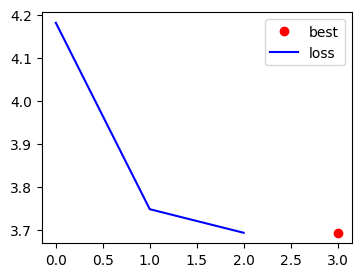

Best epoch so far:  3  smallest loss: 3.6932492463485054
Time taken for the epoch 62.699 sec

Epoch 4 Batch 3 Loss: 2.5627
Epoch 4 Batch 6 Loss: 2.7604
Epoch 4 Batch 9 Loss: 4.4089
Epoch 4 Batch 12 Loss: 3.3698
Epoch 4 Batch 15 Loss: 3.0913
Epoch 4 Batch 18 Loss: 3.8684
Epoch 4 Batch 21 Loss: 3.0796
Epoch 4 Batch 24 Loss: 3.6991

*** Epoch 4 Loss 3.6800 ***

check point saved!
Best epoch so far:  4  smallest loss: 3.6799840512483017
Time taken for the epoch 59.589 sec

Epoch 5 Batch 3 Loss: 2.9315
Epoch 5 Batch 6 Loss: 2.8233
Epoch 5 Batch 9 Loss: 4.8244
Epoch 5 Batch 12 Loss: 3.7177
Epoch 5 Batch 15 Loss: 3.2161
Epoch 5 Batch 18 Loss: 3.5873
Epoch 5 Batch 21 Loss: 3.4305
Epoch 5 Batch 24 Loss: 4.0926

*** Epoch 5 Loss 3.6724 ***

check point saved!
Best epoch so far:  5  smallest loss: 3.672449526579484
Time taken for the epoch 57.836 sec

Epoch 6 Batch 3 Loss: 3.1205
Epoch 6 Batch 6 Loss: 3.1087
Epoch 6 Batch 9 Loss: 4.9034
Epoch 6 Batch 12 Loss: 3.6942
Epoch 6 Batch 15 Loss: 2.9684


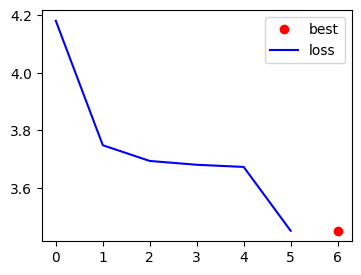

Best epoch so far:  6  smallest loss: 3.4503814033840015
Time taken for the epoch 54.599 sec

Epoch 7 Batch 3 Loss: 2.9378
Epoch 7 Batch 6 Loss: 3.7084
Epoch 7 Batch 9 Loss: 4.5875
Epoch 7 Batch 12 Loss: 3.8367
Epoch 7 Batch 15 Loss: 3.0436
Epoch 7 Batch 18 Loss: 4.1415
Epoch 7 Batch 21 Loss: 1.9940
Epoch 7 Batch 24 Loss: 3.7455

*** Epoch 7 Loss 3.6728 ***

Best epoch so far:  6  smallest loss: 3.4503814033840015
Time taken for the epoch 56.726 sec

Epoch 8 Batch 3 Loss: 2.6360
Epoch 8 Batch 6 Loss: 3.3052
Epoch 8 Batch 9 Loss: 4.4737
Epoch 8 Batch 12 Loss: 3.6832
Epoch 8 Batch 15 Loss: 2.8397
Epoch 8 Batch 18 Loss: 3.7436
Epoch 8 Batch 21 Loss: 2.4528
Epoch 8 Batch 24 Loss: 3.5564

*** Epoch 8 Loss 3.6739 ***

Best epoch so far:  6  smallest loss: 3.4503814033840015
Time taken for the epoch 56.968 sec

Epoch 9 Batch 3 Loss: 2.5316
Epoch 9 Batch 6 Loss: 2.8952
Epoch 9 Batch 9 Loss: 4.4964
Epoch 9 Batch 12 Loss: 3.3962
Epoch 9 Batch 15 Loss: 3.0315
Epoch 9 Batch 18 Loss: 3.9809
Epoch 9

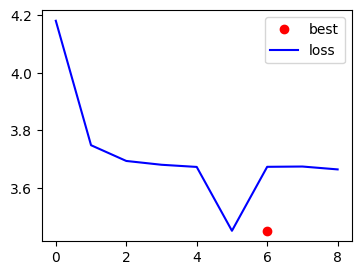

Best epoch so far:  6  smallest loss: 3.4503814033840015
Time taken for the epoch 56.131 sec

Epoch 10 Batch 3 Loss: 2.7567
Epoch 10 Batch 6 Loss: 2.8035
Epoch 10 Batch 9 Loss: 4.5949
Epoch 10 Batch 12 Loss: 3.5654
Epoch 10 Batch 15 Loss: 2.9917
Epoch 10 Batch 18 Loss: 3.5888
Epoch 10 Batch 21 Loss: 3.3029
Epoch 10 Batch 24 Loss: 3.9044

*** Epoch 10 Loss 3.6524 ***

Best epoch so far:  6  smallest loss: 3.4503814033840015
Time taken for the epoch 56.577 sec

Epoch 11 Batch 3 Loss: 3.0301
Epoch 11 Batch 6 Loss: 2.8311
Epoch 11 Batch 9 Loss: 4.7280
Epoch 11 Batch 12 Loss: 3.5954
Epoch 11 Batch 15 Loss: 3.0294
Epoch 11 Batch 18 Loss: 3.4562
Epoch 11 Batch 21 Loss: 3.5600
Epoch 11 Batch 24 Loss: 4.2869

*** Epoch 11 Loss 3.4247 ***

check point saved!
Best epoch so far:  11  smallest loss: 3.424699866253397
Time taken for the epoch 53.419 sec

Epoch 12 Batch 3 Loss: 3.0062
Epoch 12 Batch 6 Loss: 3.7870
Epoch 12 Batch 9 Loss: 4.5711
Epoch 12 Batch 12 Loss: 3.7377
Epoch 12 Batch 15 Loss: 3.

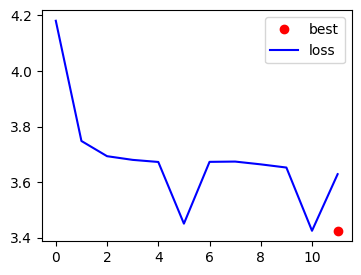

Best epoch so far:  11  smallest loss: 3.424699866253397
Time taken for the epoch 56.531 sec

Epoch 13 Batch 3 Loss: 2.6996
Epoch 13 Batch 6 Loss: 3.4821
Epoch 13 Batch 9 Loss: 4.3894
Epoch 13 Batch 12 Loss: 3.7251
Epoch 13 Batch 15 Loss: 2.9621
Epoch 13 Batch 18 Loss: 3.9127
Epoch 13 Batch 21 Loss: 2.4636
Epoch 13 Batch 24 Loss: 3.5201

*** Epoch 13 Loss 3.6078 ***

Best epoch so far:  11  smallest loss: 3.424699866253397
Time taken for the epoch 56.723 sec

Epoch 14 Batch 3 Loss: 2.5992
Epoch 14 Batch 6 Loss: 3.0491
Epoch 14 Batch 9 Loss: 4.4299
Epoch 14 Batch 12 Loss: 3.4483
Epoch 14 Batch 15 Loss: 3.0022
Epoch 14 Batch 18 Loss: 3.7061
Epoch 14 Batch 21 Loss: 2.6271
Epoch 14 Batch 24 Loss: 3.3959

*** Epoch 14 Loss 3.5823 ***

Best epoch so far:  11  smallest loss: 3.424699866253397
Time taken for the epoch 56.201 sec

Epoch 15 Batch 3 Loss: 2.6470
Epoch 15 Batch 6 Loss: 2.8060
Epoch 15 Batch 9 Loss: 4.2616
Epoch 15 Batch 12 Loss: 3.3735
Epoch 15 Batch 15 Loss: 2.8905
Epoch 15 Batch

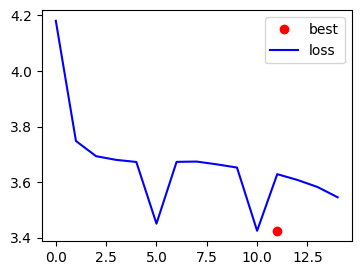

Best epoch so far:  11  smallest loss: 3.424699866253397
Time taken for the epoch 57.162 sec

Epoch 16 Batch 3 Loss: 2.8193
Epoch 16 Batch 6 Loss: 2.7362
Epoch 16 Batch 9 Loss: 4.4639
Epoch 16 Batch 12 Loss: 3.6036
Epoch 16 Batch 15 Loss: 3.0431
Epoch 16 Batch 18 Loss: 3.4574
Epoch 16 Batch 21 Loss: 3.4757
Epoch 16 Batch 24 Loss: 4.0443

*** Epoch 16 Loss 3.5145 ***

Best epoch so far:  11  smallest loss: 3.424699866253397
Time taken for the epoch 55.479 sec

Epoch 17 Batch 3 Loss: 3.1090
Epoch 17 Batch 6 Loss: 3.1168
Epoch 17 Batch 9 Loss: 4.3473
Epoch 17 Batch 12 Loss: 3.6018
Epoch 17 Batch 15 Loss: 2.8255
Epoch 17 Batch 18 Loss: 3.1081
Epoch 17 Batch 21 Loss: 3.4721
Epoch 17 Batch 24 Loss: 4.2743

*** Epoch 17 Loss 3.2731 ***

check point saved!
Best epoch so far:  17  smallest loss: 3.2730507228685464
Time taken for the epoch 54.572 sec

Epoch 18 Batch 3 Loss: 2.7903
Epoch 18 Batch 6 Loss: 3.5348
Epoch 18 Batch 9 Loss: 4.1629
Epoch 18 Batch 12 Loss: 3.5424
Epoch 18 Batch 15 Loss: 2

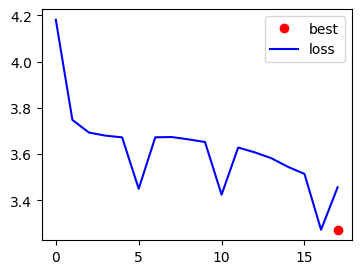

Best epoch so far:  17  smallest loss: 3.2730507228685464
Time taken for the epoch 56.915 sec

Epoch 19 Batch 3 Loss: 2.4537
Epoch 19 Batch 6 Loss: 3.0381
Epoch 19 Batch 9 Loss: 4.1449
Epoch 19 Batch 12 Loss: 3.4137
Epoch 19 Batch 15 Loss: 2.8839
Epoch 19 Batch 18 Loss: 3.5498
Epoch 19 Batch 21 Loss: 2.3864
Epoch 19 Batch 24 Loss: 3.2892

*** Epoch 19 Loss 3.4350 ***

Best epoch so far:  17  smallest loss: 3.2730507228685464
Time taken for the epoch 56.901 sec

Epoch 20 Batch 3 Loss: 2.3974
Epoch 20 Batch 6 Loss: 2.5990
Epoch 20 Batch 9 Loss: 3.9336
Epoch 20 Batch 12 Loss: 3.1486
Epoch 20 Batch 15 Loss: 2.9344
Epoch 20 Batch 18 Loss: 3.5904
Epoch 20 Batch 21 Loss: 2.8577
Epoch 20 Batch 24 Loss: 3.4623

*** Epoch 20 Loss 3.4080 ***

Best epoch so far:  17  smallest loss: 3.2730507228685464
Time taken for the epoch 55.688 sec

Epoch 21 Batch 3 Loss: 2.7372
Epoch 21 Batch 6 Loss: 2.6205
Epoch 21 Batch 9 Loss: 4.2462
Epoch 21 Batch 12 Loss: 3.4732
Epoch 21 Batch 15 Loss: 3.0384
Epoch 21 Ba

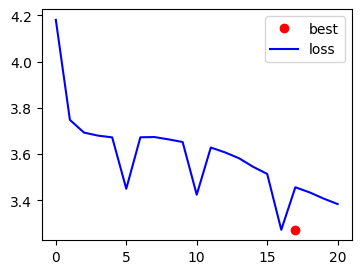

Best epoch so far:  17  smallest loss: 3.2730507228685464
Time taken for the epoch 56.468 sec

Epoch 22 Batch 3 Loss: 2.9029
Epoch 22 Batch 6 Loss: 2.8628
Epoch 22 Batch 9 Loss: 4.3178
Epoch 22 Batch 12 Loss: 3.4394
Epoch 22 Batch 15 Loss: 2.7860
Epoch 22 Batch 18 Loss: 3.0422
Epoch 22 Batch 21 Loss: 3.3562
Epoch 22 Batch 24 Loss: 3.9316

*** Epoch 22 Loss 3.1668 ***

check point saved!
Best epoch so far:  22  smallest loss: 3.16681604800017
Time taken for the epoch 53.673 sec

Epoch 23 Batch 3 Loss: 2.7168
Epoch 23 Batch 6 Loss: 3.4659
Epoch 23 Batch 9 Loss: 4.0714
Epoch 23 Batch 12 Loss: 3.4917
Epoch 23 Batch 15 Loss: 2.8544
Epoch 23 Batch 18 Loss: 3.7951
Epoch 23 Batch 21 Loss: 1.8271
Epoch 23 Batch 24 Loss: 3.4235

*** Epoch 23 Loss 3.3580 ***

Best epoch so far:  22  smallest loss: 3.16681604800017
Time taken for the epoch 57.191 sec

Epoch 24 Batch 3 Loss: 2.4264
Epoch 24 Batch 6 Loss: 3.0708
Epoch 24 Batch 9 Loss: 3.9666
Epoch 24 Batch 12 Loss: 3.3430
Epoch 24 Batch 15 Loss: 2.6

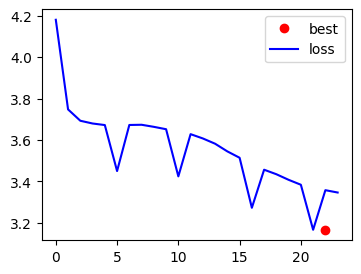

Best epoch so far:  22  smallest loss: 3.16681604800017
Time taken for the epoch 55.391 sec

Epoch 25 Batch 3 Loss: 2.3257
Epoch 25 Batch 6 Loss: 2.6605
Epoch 25 Batch 9 Loss: 3.9514
Epoch 25 Batch 12 Loss: 3.0920
Epoch 25 Batch 15 Loss: 2.8165
Epoch 25 Batch 18 Loss: 3.6169
Epoch 25 Batch 21 Loss: 2.6254
Epoch 25 Batch 24 Loss: 3.1568

*** Epoch 25 Loss 3.3231 ***

Best epoch so far:  22  smallest loss: 3.16681604800017
Time taken for the epoch 54.967 sec

Epoch 26 Batch 3 Loss: 2.5246
Epoch 26 Batch 6 Loss: 2.5570
Epoch 26 Batch 9 Loss: 4.0085
Epoch 26 Batch 12 Loss: 3.2352
Epoch 26 Batch 15 Loss: 2.7676
Epoch 26 Batch 18 Loss: 3.2653
Epoch 26 Batch 21 Loss: 2.9992
Epoch 26 Batch 24 Loss: 3.5577

*** Epoch 26 Loss 3.2983 ***

Best epoch so far:  22  smallest loss: 3.16681604800017
Time taken for the epoch 56.426 sec

Epoch 27 Batch 3 Loss: 2.7652
Epoch 27 Batch 6 Loss: 2.5481
Epoch 27 Batch 9 Loss: 4.0987
Epoch 27 Batch 12 Loss: 3.2538
Epoch 27 Batch 15 Loss: 2.7912
Epoch 27 Batch 18

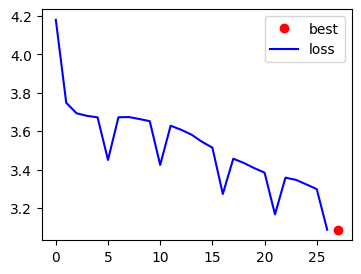

Best epoch so far:  27  smallest loss: 3.086527617081352
Time taken for the epoch 53.482 sec

Epoch 28 Batch 3 Loss: 2.7376
Epoch 28 Batch 6 Loss: 3.4563
Epoch 28 Batch 9 Loss: 4.0105
Epoch 28 Batch 12 Loss: 3.3340
Epoch 28 Batch 15 Loss: 2.8525
Epoch 28 Batch 18 Loss: 3.7446
Epoch 28 Batch 21 Loss: 1.6837
Epoch 28 Batch 24 Loss: 3.1523

*** Epoch 28 Loss 3.2600 ***

Best epoch so far:  27  smallest loss: 3.086527617081352
Time taken for the epoch 55.574 sec

Epoch 29 Batch 3 Loss: 2.4561
Epoch 29 Batch 6 Loss: 3.1810
Epoch 29 Batch 9 Loss: 3.8400
Epoch 29 Batch 12 Loss: 3.3273
Epoch 29 Batch 15 Loss: 2.7352
Epoch 29 Batch 18 Loss: 3.5239
Epoch 29 Batch 21 Loss: 2.2473
Epoch 29 Batch 24 Loss: 3.1757

*** Epoch 29 Loss 3.2374 ***

Best epoch so far:  27  smallest loss: 3.086527617081352
Time taken for the epoch 53.970 sec

Epoch 30 Batch 3 Loss: 2.3733
Epoch 30 Batch 6 Loss: 2.7730
Epoch 30 Batch 9 Loss: 3.8534
Epoch 30 Batch 12 Loss: 3.0719
Epoch 30 Batch 15 Loss: 2.7537
Epoch 30 Batch

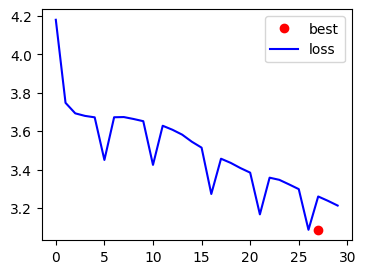

Best epoch so far:  27  smallest loss: 3.086527617081352
Time taken for the epoch 56.457 sec

Epoch 31 Batch 3 Loss: 2.4089
Epoch 31 Batch 6 Loss: 2.5339
Epoch 31 Batch 9 Loss: 3.7144
Epoch 31 Batch 12 Loss: 3.0157
Epoch 31 Batch 15 Loss: 2.6407
Epoch 31 Batch 18 Loss: 3.1677
Epoch 31 Batch 21 Loss: 2.8349
Epoch 31 Batch 24 Loss: 3.4005

*** Epoch 31 Loss 3.1746 ***

Best epoch so far:  27  smallest loss: 3.086527617081352
Time taken for the epoch 56.222 sec

Epoch 32 Batch 3 Loss: 2.5685
Epoch 32 Batch 6 Loss: 2.4610
Epoch 32 Batch 9 Loss: 3.8852
Epoch 32 Batch 12 Loss: 3.2142
Epoch 32 Batch 15 Loss: 2.7738
Epoch 32 Batch 18 Loss: 3.1500
Epoch 32 Batch 21 Loss: 3.1438
Epoch 32 Batch 24 Loss: 3.6675

*** Epoch 32 Loss 3.1483 ***

Best epoch so far:  27  smallest loss: 3.086527617081352
Time taken for the epoch 54.487 sec

Epoch 33 Batch 3 Loss: 2.8227
Epoch 33 Batch 6 Loss: 2.7909
Epoch 33 Batch 9 Loss: 3.7869
Epoch 33 Batch 12 Loss: 3.2160
Epoch 33 Batch 15 Loss: 2.5519
Epoch 33 Batch

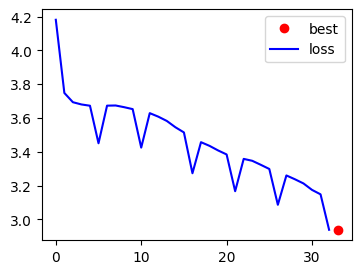

Best epoch so far:  33  smallest loss: 2.9387054443359375
Time taken for the epoch 54.118 sec

Epoch 34 Batch 3 Loss: 2.5291
Epoch 34 Batch 6 Loss: 3.2009
Epoch 34 Batch 9 Loss: 3.6820
Epoch 34 Batch 12 Loss: 3.1760
Epoch 34 Batch 15 Loss: 2.6358
Epoch 34 Batch 18 Loss: 3.5700
Epoch 34 Batch 21 Loss: 1.8931
Epoch 34 Batch 24 Loss: 3.0538

*** Epoch 34 Loss 3.0976 ***

Best epoch so far:  33  smallest loss: 2.9387054443359375
Time taken for the epoch 56.244 sec

Epoch 35 Batch 3 Loss: 2.2446
Epoch 35 Batch 6 Loss: 2.7446
Epoch 35 Batch 9 Loss: 3.6506
Epoch 35 Batch 12 Loss: 3.0513
Epoch 35 Batch 15 Loss: 2.6246
Epoch 35 Batch 18 Loss: 3.1958
Epoch 35 Batch 21 Loss: 2.1667
Epoch 35 Batch 24 Loss: 2.9539

*** Epoch 35 Loss 3.0719 ***

Best epoch so far:  33  smallest loss: 2.9387054443359375
Time taken for the epoch 55.322 sec

Epoch 36 Batch 3 Loss: 2.1896
Epoch 36 Batch 6 Loss: 2.3336
Epoch 36 Batch 9 Loss: 3.4433
Epoch 36 Batch 12 Loss: 2.8042
Epoch 36 Batch 15 Loss: 2.6546
Epoch 36 Ba

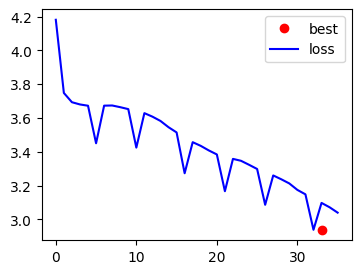

Best epoch so far:  33  smallest loss: 2.9387054443359375
Time taken for the epoch 53.866 sec

Epoch 37 Batch 3 Loss: 2.4901
Epoch 37 Batch 6 Loss: 2.3451
Epoch 37 Batch 9 Loss: 3.6801
Epoch 37 Batch 12 Loss: 3.0829
Epoch 37 Batch 15 Loss: 2.7303
Epoch 37 Batch 18 Loss: 2.9927
Epoch 37 Batch 21 Loss: 2.8393
Epoch 37 Batch 24 Loss: 3.4255

*** Epoch 37 Loss 3.0106 ***

Best epoch so far:  33  smallest loss: 2.9387054443359375
Time taken for the epoch 54.362 sec

Epoch 38 Batch 3 Loss: 2.6239
Epoch 38 Batch 6 Loss: 2.5333
Epoch 38 Batch 9 Loss: 3.7245
Epoch 38 Batch 12 Loss: 3.0485
Epoch 38 Batch 15 Loss: 2.4946
Epoch 38 Batch 18 Loss: 2.7270
Epoch 38 Batch 21 Loss: 2.9996
Epoch 38 Batch 24 Loss: 3.5141

*** Epoch 38 Loss 2.8137 ***

check point saved!
Best epoch so far:  38  smallest loss: 2.8137416010317593
Time taken for the epoch 52.115 sec

Epoch 39 Batch 3 Loss: 2.4403
Epoch 39 Batch 6 Loss: 3.0832
Epoch 39 Batch 9 Loss: 3.5675
Epoch 39 Batch 12 Loss: 3.0957
Epoch 39 Batch 15 Loss:

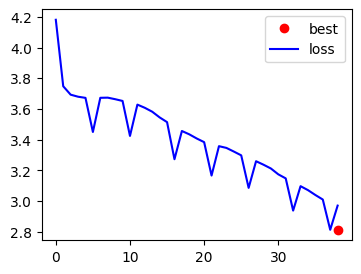

Best epoch so far:  38  smallest loss: 2.8137416010317593
Time taken for the epoch 53.178 sec

Epoch 40 Batch 3 Loss: 2.1939
Epoch 40 Batch 6 Loss: 2.7374
Epoch 40 Batch 9 Loss: 3.4431
Epoch 40 Batch 12 Loss: 2.9543
Epoch 40 Batch 15 Loss: 2.3843
Epoch 40 Batch 18 Loss: 3.0557
Epoch 40 Batch 21 Loss: 2.0186
Epoch 40 Batch 24 Loss: 2.8985

*** Epoch 40 Loss 2.9556 ***

Best epoch so far:  38  smallest loss: 2.8137416010317593
Time taken for the epoch 54.764 sec

Epoch 41 Batch 3 Loss: 2.1004
Epoch 41 Batch 6 Loss: 2.3673
Epoch 41 Batch 9 Loss: 3.3876
Epoch 41 Batch 12 Loss: 2.7303
Epoch 41 Batch 15 Loss: 2.5035
Epoch 41 Batch 18 Loss: 3.2486
Epoch 41 Batch 21 Loss: 2.3431
Epoch 41 Batch 24 Loss: 2.8007

*** Epoch 41 Loss 2.9290 ***

Best epoch so far:  38  smallest loss: 2.8137416010317593
Time taken for the epoch 52.916 sec

Epoch 42 Batch 3 Loss: 2.2667
Epoch 42 Batch 6 Loss: 2.2544
Epoch 42 Batch 9 Loss: 3.4212
Epoch 42 Batch 12 Loss: 2.8850
Epoch 42 Batch 15 Loss: 2.4496
Epoch 42 Ba

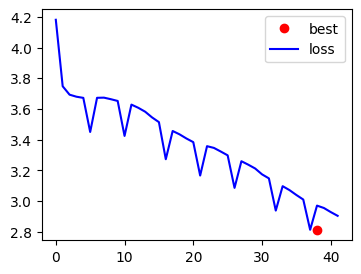

Best epoch so far:  38  smallest loss: 2.8137416010317593
Time taken for the epoch 51.707 sec

Epoch 43 Batch 3 Loss: 2.4609
Epoch 43 Batch 6 Loss: 2.2364
Epoch 43 Batch 9 Loss: 3.4792
Epoch 43 Batch 12 Loss: 2.9018
Epoch 43 Batch 15 Loss: 2.4824
Epoch 43 Batch 18 Loss: 2.8107
Epoch 43 Batch 21 Loss: 2.8480
Epoch 43 Batch 24 Loss: 3.4598

*** Epoch 43 Loss 2.7164 ***

check point saved!
Best epoch so far:  43  smallest loss: 2.716391356095024
Time taken for the epoch 50.898 sec

Epoch 44 Batch 3 Loss: 2.4381
Epoch 44 Batch 6 Loss: 3.0289
Epoch 44 Batch 9 Loss: 3.4797
Epoch 44 Batch 12 Loss: 2.9741
Epoch 44 Batch 15 Loss: 2.5123
Epoch 44 Batch 18 Loss: 3.3454
Epoch 44 Batch 21 Loss: 1.5064
Epoch 44 Batch 24 Loss: 2.7965

*** Epoch 44 Loss 2.8638 ***

Best epoch so far:  43  smallest loss: 2.716391356095024
Time taken for the epoch 52.589 sec

Epoch 45 Batch 3 Loss: 2.1915
Epoch 45 Batch 6 Loss: 2.8037
Epoch 45 Batch 9 Loss: 3.3245
Epoch 45 Batch 12 Loss: 2.9891
Epoch 45 Batch 15 Loss: 2

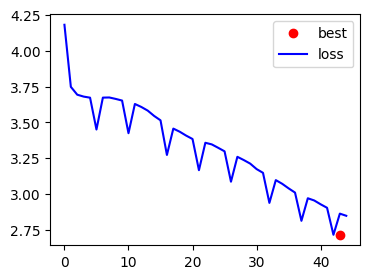

Best epoch so far:  43  smallest loss: 2.716391356095024
Time taken for the epoch 53.511 sec

Epoch 46 Batch 3 Loss: 2.1281
Epoch 46 Batch 6 Loss: 2.4460
Epoch 46 Batch 9 Loss: 3.3055
Epoch 46 Batch 12 Loss: 2.7560
Epoch 46 Batch 15 Loss: 2.4178
Epoch 46 Batch 18 Loss: 2.9887
Epoch 46 Batch 21 Loss: 2.1419
Epoch 46 Batch 24 Loss: 2.7083

*** Epoch 46 Loss 2.8301 ***

Best epoch so far:  43  smallest loss: 2.716391356095024
Time taken for the epoch 52.176 sec

Epoch 47 Batch 3 Loss: 2.1455
Epoch 47 Batch 6 Loss: 2.2310
Epoch 47 Batch 9 Loss: 3.1655
Epoch 47 Batch 12 Loss: 2.7151
Epoch 47 Batch 15 Loss: 2.3110
Epoch 47 Batch 18 Loss: 2.8394
Epoch 47 Batch 21 Loss: 2.5539
Epoch 47 Batch 24 Loss: 3.0393

*** Epoch 47 Loss 2.8059 ***

Best epoch so far:  43  smallest loss: 2.716391356095024
Time taken for the epoch 52.842 sec

Epoch 48 Batch 3 Loss: 2.2846
Epoch 48 Batch 6 Loss: 2.1655
Epoch 48 Batch 9 Loss: 3.2672
Epoch 48 Batch 12 Loss: 2.8946
Epoch 48 Batch 15 Loss: 2.4361
Epoch 48 Batch

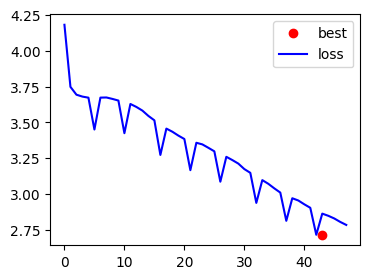

Best epoch so far:  43  smallest loss: 2.716391356095024
Time taken for the epoch 53.264 sec

Epoch 49 Batch 3 Loss: 2.5159
Epoch 49 Batch 6 Loss: 2.4389
Epoch 49 Batch 9 Loss: 3.1644
Epoch 49 Batch 12 Loss: 2.9008
Epoch 49 Batch 15 Loss: 2.2662
Epoch 49 Batch 18 Loss: 2.5501
Epoch 49 Batch 21 Loss: 2.8042
Epoch 49 Batch 24 Loss: 3.4465

*** Epoch 49 Loss 2.5989 ***

check point saved!
Best epoch so far:  49  smallest loss: 2.598903821862262
Time taken for the epoch 48.106 sec

Epoch 50 Batch 3 Loss: 2.2407
Epoch 50 Batch 6 Loss: 2.8035
Epoch 50 Batch 9 Loss: 3.2290
Epoch 50 Batch 12 Loss: 2.8659
Epoch 50 Batch 15 Loss: 2.3117
Epoch 50 Batch 18 Loss: 3.2012
Epoch 50 Batch 21 Loss: 1.7045
Epoch 50 Batch 24 Loss: 2.7355

*** Epoch 50 Loss 2.7404 ***

Best epoch so far:  49  smallest loss: 2.598903821862262
Time taken for the epoch 53.039 sec

Epoch 51 Batch 3 Loss: 1.9976
Epoch 51 Batch 6 Loss: 2.4091
Epoch 51 Batch 9 Loss: 3.2109
Epoch 51 Batch 12 Loss: 2.7372
Epoch 51 Batch 15 Loss: 2.

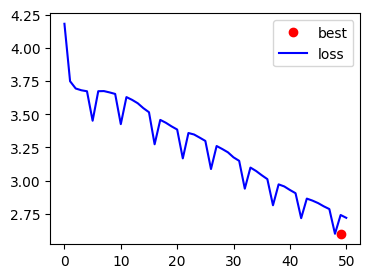

Best epoch so far:  49  smallest loss: 2.598903821862262
Time taken for the epoch 53.241 sec

Epoch 52 Batch 3 Loss: 1.9363
Epoch 52 Batch 6 Loss: 2.0446
Epoch 52 Batch 9 Loss: 2.9887
Epoch 52 Batch 12 Loss: 2.5382
Epoch 52 Batch 15 Loss: 2.2969
Epoch 52 Batch 18 Loss: 2.8950
Epoch 52 Batch 21 Loss: 2.3297
Epoch 52 Batch 24 Loss: 2.7825

*** Epoch 52 Loss 2.6972 ***

Best epoch so far:  49  smallest loss: 2.598903821862262
Time taken for the epoch 54.165 sec

Epoch 53 Batch 3 Loss: 2.2383
Epoch 53 Batch 6 Loss: 2.0612
Epoch 53 Batch 9 Loss: 3.1599
Epoch 53 Batch 12 Loss: 2.7883
Epoch 53 Batch 15 Loss: 2.3928
Epoch 53 Batch 18 Loss: 2.7274
Epoch 53 Batch 21 Loss: 2.5868
Epoch 53 Batch 24 Loss: 3.0897

*** Epoch 53 Loss 2.6825 ***

Best epoch so far:  49  smallest loss: 2.598903821862262
Time taken for the epoch 52.310 sec

Epoch 54 Batch 3 Loss: 2.3518
Epoch 54 Batch 6 Loss: 2.2466
Epoch 54 Batch 9 Loss: 3.2293
Epoch 54 Batch 12 Loss: 2.7385
Epoch 54 Batch 15 Loss: 2.2123
Epoch 54 Batch

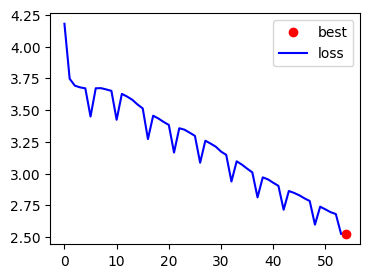

Best epoch so far:  54  smallest loss: 2.526974221934443
Time taken for the epoch 49.608 sec

Epoch 55 Batch 3 Loss: 2.1864
Epoch 55 Batch 6 Loss: 2.7137
Epoch 55 Batch 9 Loss: 3.1695
Epoch 55 Batch 12 Loss: 2.8893
Epoch 55 Batch 15 Loss: 2.2317
Epoch 55 Batch 18 Loss: 3.0520
Epoch 55 Batch 21 Loss: 1.5114
Epoch 55 Batch 24 Loss: 2.8438

*** Epoch 55 Loss 2.6668 ***

Best epoch so far:  54  smallest loss: 2.526974221934443
Time taken for the epoch 52.435 sec

Epoch 56 Batch 3 Loss: 1.9811
Epoch 56 Batch 6 Loss: 2.4421
Epoch 56 Batch 9 Loss: 3.0487
Epoch 56 Batch 12 Loss: 2.7407
Epoch 56 Batch 15 Loss: 2.0680
Epoch 56 Batch 18 Loss: 2.7493
Epoch 56 Batch 21 Loss: 1.8298
Epoch 56 Batch 24 Loss: 2.6484

*** Epoch 56 Loss 2.6482 ***

Best epoch so far:  54  smallest loss: 2.526974221934443
Time taken for the epoch 51.614 sec

Epoch 57 Batch 3 Loss: 1.9107
Epoch 57 Batch 6 Loss: 2.1241
Epoch 57 Batch 9 Loss: 2.9844
Epoch 57 Batch 12 Loss: 2.4825
Epoch 57 Batch 15 Loss: 2.1507
Epoch 57 Batch

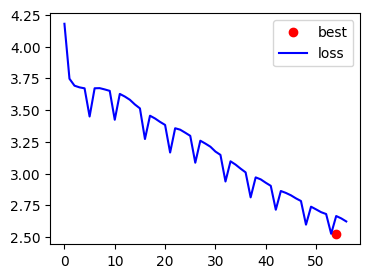

Best epoch so far:  54  smallest loss: 2.526974221934443
Time taken for the epoch 52.553 sec

Epoch 58 Batch 3 Loss: 2.0755
Epoch 58 Batch 6 Loss: 2.0273
Epoch 58 Batch 9 Loss: 2.9611
Epoch 58 Batch 12 Loss: 2.5905
Epoch 58 Batch 15 Loss: 2.1226
Epoch 58 Batch 18 Loss: 2.6547
Epoch 58 Batch 21 Loss: 2.4208
Epoch 58 Batch 24 Loss: 2.8605

*** Epoch 58 Loss 2.6045 ***

Best epoch so far:  54  smallest loss: 2.526974221934443
Time taken for the epoch 53.349 sec

Epoch 59 Batch 3 Loss: 2.2559
Epoch 59 Batch 6 Loss: 2.0189
Epoch 59 Batch 9 Loss: 2.9604
Epoch 59 Batch 12 Loss: 2.6101
Epoch 59 Batch 15 Loss: 2.1653
Epoch 59 Batch 18 Loss: 2.5895
Epoch 59 Batch 21 Loss: 2.6376
Epoch 59 Batch 24 Loss: 3.1433

*** Epoch 59 Loss 2.4465 ***

check point saved!
Best epoch so far:  59  smallest loss: 2.4465283932893174
Time taken for the epoch 47.304 sec

Epoch 60 Batch 3 Loss: 2.1730
Epoch 60 Batch 6 Loss: 2.7161
Epoch 60 Batch 9 Loss: 3.0663
Epoch 60 Batch 12 Loss: 2.7149
Epoch 60 Batch 15 Loss: 2

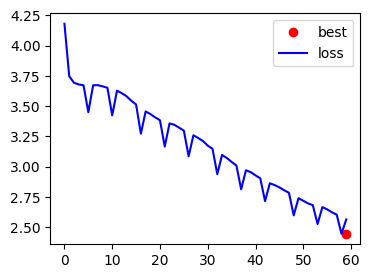

Best epoch so far:  59  smallest loss: 2.4465283932893174
Time taken for the epoch 53.802 sec

Epoch 61 Batch 3 Loss: 1.9438
Epoch 61 Batch 6 Loss: 2.4805
Epoch 61 Batch 9 Loss: 2.9329
Epoch 61 Batch 12 Loss: 2.7171
Epoch 61 Batch 15 Loss: 2.0890
Epoch 61 Batch 18 Loss: 2.8143
Epoch 61 Batch 21 Loss: 1.8246
Epoch 61 Batch 24 Loss: 2.5498

*** Epoch 61 Loss 2.5400 ***

Best epoch so far:  59  smallest loss: 2.4465283932893174
Time taken for the epoch 51.441 sec

Epoch 62 Batch 3 Loss: 1.8928
Epoch 62 Batch 6 Loss: 2.1728
Epoch 62 Batch 9 Loss: 2.8775
Epoch 62 Batch 12 Loss: 2.4971
Epoch 62 Batch 15 Loss: 2.0787
Epoch 62 Batch 18 Loss: 2.6702
Epoch 62 Batch 21 Loss: 1.9339
Epoch 62 Batch 24 Loss: 2.3986

*** Epoch 62 Loss 2.5140 ***

Best epoch so far:  59  smallest loss: 2.4465283932893174
Time taken for the epoch 53.190 sec

Epoch 63 Batch 3 Loss: 1.9227
Epoch 63 Batch 6 Loss: 1.9624
Epoch 63 Batch 9 Loss: 2.7610
Epoch 63 Batch 12 Loss: 2.4443
Epoch 63 Batch 15 Loss: 1.9748
Epoch 63 Ba

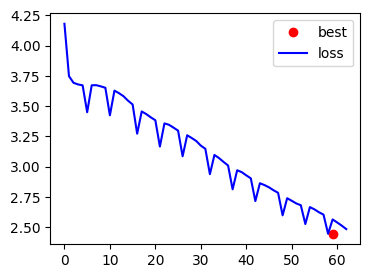

Best epoch so far:  59  smallest loss: 2.4465283932893174
Time taken for the epoch 53.438 sec

Epoch 64 Batch 3 Loss: 2.0543
Epoch 64 Batch 6 Loss: 1.8941
Epoch 64 Batch 9 Loss: 2.8729
Epoch 64 Batch 12 Loss: 2.6100
Epoch 64 Batch 15 Loss: 2.1056
Epoch 64 Batch 18 Loss: 2.5231
Epoch 64 Batch 21 Loss: 2.5513
Epoch 64 Batch 24 Loss: 2.9328

*** Epoch 64 Loss 2.4700 ***

Best epoch so far:  59  smallest loss: 2.4465283932893174
Time taken for the epoch 54.038 sec

Epoch 65 Batch 3 Loss: 2.2297
Epoch 65 Batch 6 Loss: 2.1598
Epoch 65 Batch 9 Loss: 2.8215
Epoch 65 Batch 12 Loss: 2.6174
Epoch 65 Batch 15 Loss: 1.9910
Epoch 65 Batch 18 Loss: 2.3012
Epoch 65 Batch 21 Loss: 2.5141
Epoch 65 Batch 24 Loss: 3.0939

*** Epoch 65 Loss 2.3153 ***

check point saved!
Best epoch so far:  65  smallest loss: 2.3153368079144023
Time taken for the epoch 50.691 sec

Epoch 66 Batch 3 Loss: 1.9782
Epoch 66 Batch 6 Loss: 2.4469
Epoch 66 Batch 9 Loss: 2.8350
Epoch 66 Batch 12 Loss: 2.6096
Epoch 66 Batch 15 Loss:

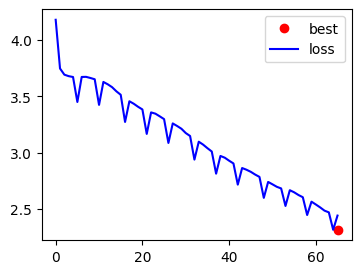

Best epoch so far:  65  smallest loss: 2.3153368079144023
Time taken for the epoch 54.799 sec

Epoch 67 Batch 3 Loss: 1.7914
Epoch 67 Batch 6 Loss: 2.1428
Epoch 67 Batch 9 Loss: 2.7725
Epoch 67 Batch 12 Loss: 2.4899
Epoch 67 Batch 15 Loss: 2.0001
Epoch 67 Batch 18 Loss: 2.5732
Epoch 67 Batch 21 Loss: 1.7634
Epoch 67 Batch 24 Loss: 2.3418

*** Epoch 67 Loss 2.4319 ***

Best epoch so far:  65  smallest loss: 2.3153368079144023
Time taken for the epoch 52.892 sec

Epoch 68 Batch 3 Loss: 1.7337
Epoch 68 Batch 6 Loss: 1.8266
Epoch 68 Batch 9 Loss: 2.5389
Epoch 68 Batch 12 Loss: 2.3179
Epoch 68 Batch 15 Loss: 1.9904
Epoch 68 Batch 18 Loss: 2.5659
Epoch 68 Batch 21 Loss: 2.1031
Epoch 68 Batch 24 Loss: 2.4940

*** Epoch 68 Loss 2.4069 ***

Best epoch so far:  65  smallest loss: 2.3153368079144023
Time taken for the epoch 51.076 sec

Epoch 69 Batch 3 Loss: 2.0365
Epoch 69 Batch 6 Loss: 1.7988
Epoch 69 Batch 9 Loss: 2.6398
Epoch 69 Batch 12 Loss: 2.5461
Epoch 69 Batch 15 Loss: 2.0804
Epoch 69 Ba

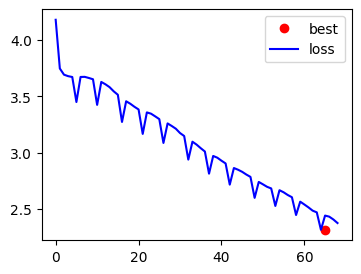

Best epoch so far:  65  smallest loss: 2.3153368079144023
Time taken for the epoch 52.828 sec

Epoch 70 Batch 3 Loss: 2.1191
Epoch 70 Batch 6 Loss: 1.9719
Epoch 70 Batch 9 Loss: 2.6731
Epoch 70 Batch 12 Loss: 2.4733
Epoch 70 Batch 15 Loss: 1.9441
Epoch 70 Batch 18 Loss: 2.2522
Epoch 70 Batch 21 Loss: 2.4174
Epoch 70 Batch 24 Loss: 2.7648

*** Epoch 70 Loss 2.2180 ***

check point saved!
Best epoch so far:  70  smallest loss: 2.2180449444314707
Time taken for the epoch 48.760 sec

Epoch 71 Batch 3 Loss: 1.8865
Epoch 71 Batch 6 Loss: 2.3875
Epoch 71 Batch 9 Loss: 2.7197
Epoch 71 Batch 12 Loss: 2.5033
Epoch 71 Batch 15 Loss: 1.9203
Epoch 71 Batch 18 Loss: 2.7500
Epoch 71 Batch 21 Loss: 1.3274
Epoch 71 Batch 24 Loss: 2.4582

*** Epoch 71 Loss 2.3320 ***

Best epoch so far:  70  smallest loss: 2.2180449444314707
Time taken for the epoch 51.694 sec

Epoch 72 Batch 3 Loss: 1.7048
Epoch 72 Batch 6 Loss: 2.1574
Epoch 72 Batch 9 Loss: 2.6321
Epoch 72 Batch 12 Loss: 2.3935
Epoch 72 Batch 15 Loss:

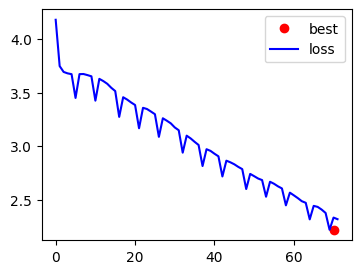

Best epoch so far:  70  smallest loss: 2.2180449444314707
Time taken for the epoch 52.639 sec

Epoch 73 Batch 3 Loss: 1.6356
Epoch 73 Batch 6 Loss: 1.8411
Epoch 73 Batch 9 Loss: 2.5066
Epoch 73 Batch 12 Loss: 2.2170
Epoch 73 Batch 15 Loss: 1.8076
Epoch 73 Batch 18 Loss: 2.5695
Epoch 73 Batch 21 Loss: 1.8609
Epoch 73 Batch 24 Loss: 2.1924

*** Epoch 73 Loss 2.2770 ***

Best epoch so far:  70  smallest loss: 2.2180449444314707
Time taken for the epoch 52.940 sec

Epoch 74 Batch 3 Loss: 1.7654
Epoch 74 Batch 6 Loss: 1.7049
Epoch 74 Batch 9 Loss: 2.4484
Epoch 74 Batch 12 Loss: 2.3282
Epoch 74 Batch 15 Loss: 1.7858
Epoch 74 Batch 18 Loss: 2.2781
Epoch 74 Batch 21 Loss: 2.1218
Epoch 74 Batch 24 Loss: 2.4968

*** Epoch 74 Loss 2.2440 ***

Best epoch so far:  70  smallest loss: 2.2180449444314707
Time taken for the epoch 51.412 sec

Epoch 75 Batch 3 Loss: 1.9219
Epoch 75 Batch 6 Loss: 1.6681
Epoch 75 Batch 9 Loss: 2.4117
Epoch 75 Batch 12 Loss: 2.3269
Epoch 75 Batch 15 Loss: 1.8461
Epoch 75 Ba

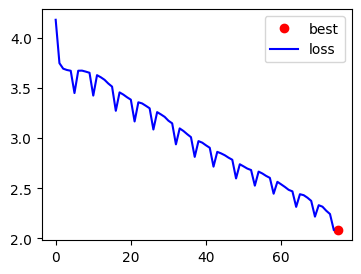

Best epoch so far:  75  smallest loss: 2.0869260041610054
Time taken for the epoch 49.886 sec

Epoch 76 Batch 3 Loss: 1.8144
Epoch 76 Batch 6 Loss: 2.2705
Epoch 76 Batch 9 Loss: 2.5854
Epoch 76 Batch 12 Loss: 2.3463
Epoch 76 Batch 15 Loss: 1.8567
Epoch 76 Batch 18 Loss: 2.5975
Epoch 76 Batch 21 Loss: 1.1917
Epoch 76 Batch 24 Loss: 2.1801

*** Epoch 76 Loss 2.1866 ***

Best epoch so far:  75  smallest loss: 2.0869260041610054
Time taken for the epoch 53.322 sec

Epoch 77 Batch 3 Loss: 1.6433
Epoch 77 Batch 6 Loss: 2.0773
Epoch 77 Batch 9 Loss: 2.4579
Epoch 77 Batch 12 Loss: 2.3389
Epoch 77 Batch 15 Loss: 1.7468
Epoch 77 Batch 18 Loss: 2.4543
Epoch 77 Batch 21 Loss: 1.5675
Epoch 77 Batch 24 Loss: 2.1742

*** Epoch 77 Loss 2.1649 ***

Best epoch so far:  75  smallest loss: 2.0869260041610054
Time taken for the epoch 51.515 sec

Epoch 78 Batch 3 Loss: 1.5955
Epoch 78 Batch 6 Loss: 1.8376
Epoch 78 Batch 9 Loss: 2.3933
Epoch 78 Batch 12 Loss: 2.1524
Epoch 78 Batch 15 Loss: 1.7393
Epoch 78 Ba

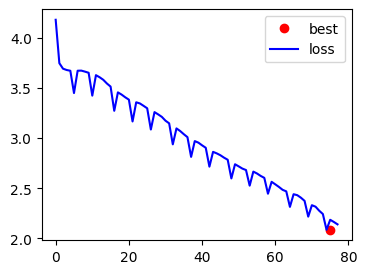

Best epoch so far:  75  smallest loss: 2.0869260041610054
Time taken for the epoch 52.154 sec

Epoch 79 Batch 3 Loss: 1.6313
Epoch 79 Batch 6 Loss: 1.6352
Epoch 79 Batch 9 Loss: 2.2402
Epoch 79 Batch 12 Loss: 2.1362
Epoch 79 Batch 15 Loss: 1.6404
Epoch 79 Batch 18 Loss: 2.1888
Epoch 79 Batch 21 Loss: 1.9652
Epoch 79 Batch 24 Loss: 2.3079

*** Epoch 79 Loss 2.1143 ***

Best epoch so far:  75  smallest loss: 2.0869260041610054
Time taken for the epoch 50.790 sec

Epoch 80 Batch 3 Loss: 1.7500
Epoch 80 Batch 6 Loss: 1.5798
Epoch 80 Batch 9 Loss: 2.2966
Epoch 80 Batch 12 Loss: 2.2685
Epoch 80 Batch 15 Loss: 1.7756
Epoch 80 Batch 18 Loss: 2.2008
Epoch 80 Batch 21 Loss: 2.2076
Epoch 80 Batch 24 Loss: 2.5078

*** Epoch 80 Loss 2.1030 ***

Best epoch so far:  75  smallest loss: 2.0869260041610054
Time taken for the epoch 51.160 sec

Epoch 81 Batch 3 Loss: 1.8959
Epoch 81 Batch 6 Loss: 1.8098
Epoch 81 Batch 9 Loss: 2.2579
Epoch 81 Batch 12 Loss: 2.2975
Epoch 81 Batch 15 Loss: 1.6643
Epoch 81 Ba

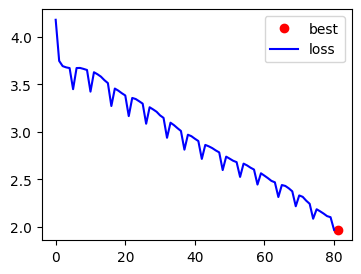

Best epoch so far:  81  smallest loss: 1.9705604884935461
Time taken for the epoch 50.553 sec

Epoch 82 Batch 3 Loss: 1.6566
Epoch 82 Batch 6 Loss: 2.0694
Epoch 82 Batch 9 Loss: 2.4290
Epoch 82 Batch 12 Loss: 2.2308
Epoch 82 Batch 15 Loss: 1.6591
Epoch 82 Batch 18 Loss: 2.4763
Epoch 82 Batch 21 Loss: 1.3459
Epoch 82 Batch 24 Loss: 2.1117

*** Epoch 82 Loss 2.0810 ***

Best epoch so far:  81  smallest loss: 1.9705604884935461
Time taken for the epoch 50.734 sec

Epoch 83 Batch 3 Loss: 1.5047
Epoch 83 Batch 6 Loss: 1.8232
Epoch 83 Batch 9 Loss: 2.3337
Epoch 83 Batch 12 Loss: 2.1543
Epoch 83 Batch 15 Loss: 1.6460
Epoch 83 Batch 18 Loss: 2.2527
Epoch 83 Batch 21 Loss: 1.5171
Epoch 83 Batch 24 Loss: 1.9853

*** Epoch 83 Loss 2.0641 ***

Best epoch so far:  81  smallest loss: 1.9705604884935461
Time taken for the epoch 54.018 sec

Epoch 84 Batch 3 Loss: 1.4475
Epoch 84 Batch 6 Loss: 1.5320
Epoch 84 Batch 9 Loss: 2.1303
Epoch 84 Batch 12 Loss: 1.9653
Epoch 84 Batch 15 Loss: 1.6148
Epoch 84 Ba

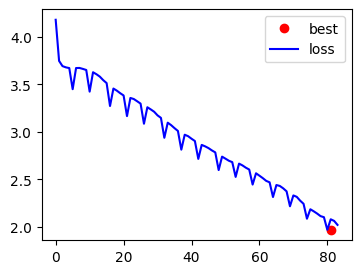

Best epoch so far:  81  smallest loss: 1.9705604884935461
Time taken for the epoch 51.982 sec

Epoch 85 Batch 3 Loss: 1.6857
Epoch 85 Batch 6 Loss: 1.4923
Epoch 85 Batch 9 Loss: 2.2091
Epoch 85 Batch 12 Loss: 2.1493
Epoch 85 Batch 15 Loss: 1.6802
Epoch 85 Batch 18 Loss: 2.0799
Epoch 85 Batch 21 Loss: 1.9606
Epoch 85 Batch 24 Loss: 2.3107

*** Epoch 85 Loss 1.9920 ***

Best epoch so far:  81  smallest loss: 1.9705604884935461
Time taken for the epoch 53.053 sec

Epoch 86 Batch 3 Loss: 1.7417
Epoch 86 Batch 6 Loss: 1.6105
Epoch 86 Batch 9 Loss: 2.2022
Epoch 86 Batch 12 Loss: 2.1248
Epoch 86 Batch 15 Loss: 1.5755
Epoch 86 Batch 18 Loss: 1.9049
Epoch 86 Batch 21 Loss: 2.0639
Epoch 86 Batch 24 Loss: 2.3464

*** Epoch 86 Loss 1.8565 ***

check point saved!
Best epoch so far:  86  smallest loss: 1.8564607371454653
Time taken for the epoch 50.752 sec

Epoch 87 Batch 3 Loss: 1.5343
Epoch 87 Batch 6 Loss: 1.9530
Epoch 87 Batch 9 Loss: 2.2700
Epoch 87 Batch 12 Loss: 2.1416
Epoch 87 Batch 15 Loss:

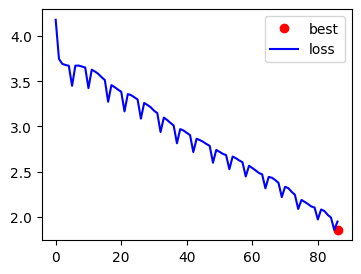

Best epoch so far:  86  smallest loss: 1.8564607371454653
Time taken for the epoch 54.219 sec

Epoch 88 Batch 3 Loss: 1.4049
Epoch 88 Batch 6 Loss: 1.7367
Epoch 88 Batch 9 Loss: 2.1825
Epoch 88 Batch 12 Loss: 2.0449
Epoch 88 Batch 15 Loss: 1.4335
Epoch 88 Batch 18 Loss: 2.0737
Epoch 88 Batch 21 Loss: 1.3774
Epoch 88 Batch 24 Loss: 1.9198

*** Epoch 88 Loss 1.9331 ***

Best epoch so far:  86  smallest loss: 1.8564607371454653
Time taken for the epoch 52.812 sec

Epoch 89 Batch 3 Loss: 1.3469
Epoch 89 Batch 6 Loss: 1.5015
Epoch 89 Batch 9 Loss: 2.0757
Epoch 89 Batch 12 Loss: 1.8980
Epoch 89 Batch 15 Loss: 1.4812
Epoch 89 Batch 18 Loss: 2.1832
Epoch 89 Batch 21 Loss: 1.5917
Epoch 89 Batch 24 Loss: 1.8143

*** Epoch 89 Loss 1.9073 ***

Best epoch so far:  86  smallest loss: 1.8564607371454653
Time taken for the epoch 53.356 sec

Epoch 90 Batch 3 Loss: 1.4909
Epoch 90 Batch 6 Loss: 1.4035
Epoch 90 Batch 9 Loss: 2.0051
Epoch 90 Batch 12 Loss: 2.0034
Epoch 90 Batch 15 Loss: 1.4676
Epoch 90 Ba

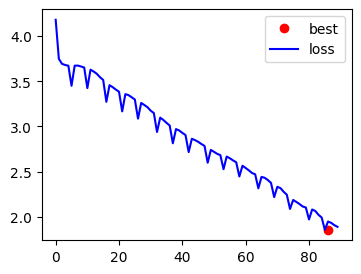

Best epoch so far:  86  smallest loss: 1.8564607371454653
Time taken for the epoch 50.775 sec

Epoch 91 Batch 3 Loss: 1.6170
Epoch 91 Batch 6 Loss: 1.3703
Epoch 91 Batch 9 Loss: 1.9870
Epoch 91 Batch 12 Loss: 1.9810
Epoch 91 Batch 15 Loss: 1.5413
Epoch 91 Batch 18 Loss: 1.8950
Epoch 91 Batch 21 Loss: 1.9190
Epoch 91 Batch 24 Loss: 2.2869

*** Epoch 91 Loss 1.7578 ***

check point saved!
Best epoch so far:  91  smallest loss: 1.7577567722486414
Time taken for the epoch 50.048 sec

Epoch 92 Batch 3 Loss: 1.4863
Epoch 92 Batch 6 Loss: 1.9061
Epoch 92 Batch 9 Loss: 2.2049
Epoch 92 Batch 12 Loss: 1.9939
Epoch 92 Batch 15 Loss: 1.5070
Epoch 92 Batch 18 Loss: 2.2417
Epoch 92 Batch 21 Loss: 1.0368
Epoch 92 Batch 24 Loss: 1.8673

*** Epoch 92 Loss 1.8465 ***

Best epoch so far:  91  smallest loss: 1.7577567722486414
Time taken for the epoch 49.849 sec

Epoch 93 Batch 3 Loss: 1.3622
Epoch 93 Batch 6 Loss: 1.7036
Epoch 93 Batch 9 Loss: 2.0664
Epoch 93 Batch 12 Loss: 2.0049
Epoch 93 Batch 15 Loss:

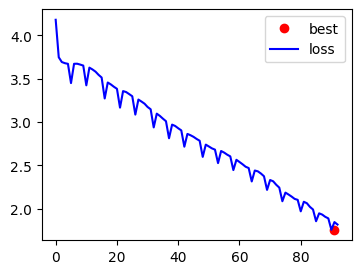

Best epoch so far:  91  smallest loss: 1.7577567722486414
Time taken for the epoch 51.474 sec

Epoch 94 Batch 3 Loss: 1.3230
Epoch 94 Batch 6 Loss: 1.5060
Epoch 94 Batch 9 Loss: 2.0198
Epoch 94 Batch 12 Loss: 1.8512
Epoch 94 Batch 15 Loss: 1.4084
Epoch 94 Batch 18 Loss: 1.9469
Epoch 94 Batch 21 Loss: 1.3995
Epoch 94 Batch 24 Loss: 1.7093

*** Epoch 94 Loss 1.7924 ***

Best epoch so far:  91  smallest loss: 1.7577567722486414
Time taken for the epoch 51.040 sec

Epoch 95 Batch 3 Loss: 1.3549
Epoch 95 Batch 6 Loss: 1.3283
Epoch 95 Batch 9 Loss: 1.8504
Epoch 95 Batch 12 Loss: 1.8111
Epoch 95 Batch 15 Loss: 1.3090
Epoch 95 Batch 18 Loss: 1.8567
Epoch 95 Batch 21 Loss: 1.6339
Epoch 95 Batch 24 Loss: 1.9283

*** Epoch 95 Loss 1.7551 ***

check point saved!
Best epoch so far:  95  smallest loss: 1.7550506591796875
Time taken for the epoch 51.248 sec

Epoch 96 Batch 3 Loss: 1.4544
Epoch 96 Batch 6 Loss: 1.2729
Epoch 96 Batch 9 Loss: 1.8594
Epoch 96 Batch 12 Loss: 1.9021
Epoch 96 Batch 15 Loss:

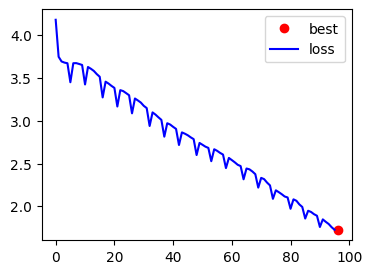

Best epoch so far:  96  smallest loss: 1.725034464960513
Time taken for the epoch 51.439 sec

Epoch 97 Batch 3 Loss: 1.5363
Epoch 97 Batch 6 Loss: 1.4479
Epoch 97 Batch 9 Loss: 1.8176
Epoch 97 Batch 12 Loss: 1.9270
Epoch 97 Batch 15 Loss: 1.3532
Epoch 97 Batch 18 Loss: 1.6567
Epoch 97 Batch 21 Loss: 1.7455
Epoch 97 Batch 24 Loss: 2.1535

*** Epoch 97 Loss 1.6037 ***

check point saved!
Best epoch so far:  97  smallest loss: 1.6036940864894702
Time taken for the epoch 48.706 sec

Epoch 98 Batch 3 Loss: 1.3231
Epoch 98 Batch 6 Loss: 1.6385
Epoch 98 Batch 9 Loss: 1.9139
Epoch 98 Batch 12 Loss: 1.8222
Epoch 98 Batch 15 Loss: 1.3034
Epoch 98 Batch 18 Loss: 2.0596
Epoch 98 Batch 21 Loss: 1.1015
Epoch 98 Batch 24 Loss: 1.7043

*** Epoch 98 Loss 1.6807 ***

Best epoch so far:  97  smallest loss: 1.6036940864894702
Time taken for the epoch 49.952 sec

Epoch 99 Batch 3 Loss: 1.2004
Epoch 99 Batch 6 Loss: 1.4311
Epoch 99 Batch 9 Loss: 1.8771
Epoch 99 Batch 12 Loss: 1.7504
Epoch 99 Batch 15 Loss: 

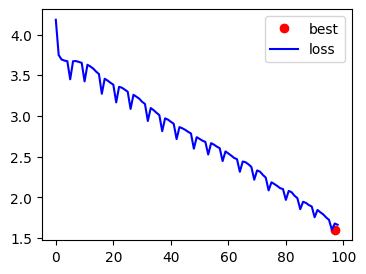

Best epoch so far:  97  smallest loss: 1.6036940864894702
Time taken for the epoch 51.543 sec

Epoch 100 Batch 3 Loss: 1.1472
Epoch 100 Batch 6 Loss: 1.2183
Epoch 100 Batch 9 Loss: 1.7723
Epoch 100 Batch 12 Loss: 1.6594
Epoch 100 Batch 15 Loss: 1.3044
Epoch 100 Batch 18 Loss: 1.8141
Epoch 100 Batch 21 Loss: 1.4869
Epoch 100 Batch 24 Loss: 1.7029

*** Epoch 100 Loss 1.6572 ***

Best epoch so far:  97  smallest loss: 1.6036940864894702
Time taken for the epoch 52.093 sec

Epoch 101 Batch 3 Loss: 1.3655
Epoch 101 Batch 6 Loss: 1.1761
Epoch 101 Batch 9 Loss: 1.7959
Epoch 101 Batch 12 Loss: 1.8639
Epoch 101 Batch 15 Loss: 1.3244
Epoch 101 Batch 18 Loss: 1.7926
Epoch 101 Batch 21 Loss: 1.6564
Epoch 101 Batch 24 Loss: 1.9296

*** Epoch 101 Loss 1.6501 ***

Best epoch so far:  97  smallest loss: 1.6036940864894702
Time taken for the epoch 51.756 sec

Epoch 102 Batch 3 Loss: 1.4141
Epoch 102 Batch 6 Loss: 1.2871
Epoch 102 Batch 9 Loss: 1.8338
Epoch 102 Batch 12 Loss: 1.7931
Epoch 102 Batch 15 L

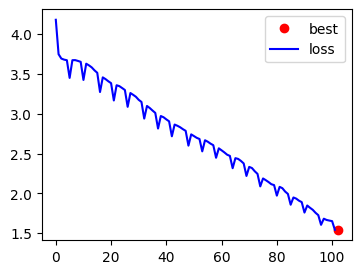

Best epoch so far:  102  smallest loss: 1.5414758765179177
Time taken for the epoch 47.124 sec

Epoch 103 Batch 3 Loss: 1.2592
Epoch 103 Batch 6 Loss: 1.5779
Epoch 103 Batch 9 Loss: 1.9505
Epoch 103 Batch 12 Loss: 1.8492
Epoch 103 Batch 15 Loss: 1.2935
Epoch 103 Batch 18 Loss: 1.9766
Epoch 103 Batch 21 Loss: 0.9519
Epoch 103 Batch 24 Loss: 1.7359

*** Epoch 103 Loss 1.6354 ***

Best epoch so far:  102  smallest loss: 1.5414758765179177
Time taken for the epoch 52.298 sec

Epoch 104 Batch 3 Loss: 1.1624
Epoch 104 Batch 6 Loss: 1.4120
Epoch 104 Batch 9 Loss: 1.8176
Epoch 104 Batch 12 Loss: 1.7385
Epoch 104 Batch 15 Loss: 1.1636
Epoch 104 Batch 18 Loss: 1.7771
Epoch 104 Batch 21 Loss: 1.1561
Epoch 104 Batch 24 Loss: 1.5590

*** Epoch 104 Loss 1.6135 ***

Best epoch so far:  102  smallest loss: 1.5414758765179177
Time taken for the epoch 51.539 sec

Epoch 105 Batch 3 Loss: 1.0973
Epoch 105 Batch 6 Loss: 1.2446
Epoch 105 Batch 9 Loss: 1.7556
Epoch 105 Batch 12 Loss: 1.6126
Epoch 105 Batch 1

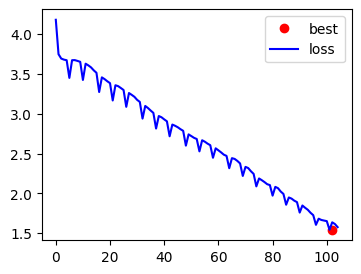

Best epoch so far:  102  smallest loss: 1.5414758765179177
Time taken for the epoch 51.042 sec

Epoch 106 Batch 3 Loss: 1.2068
Epoch 106 Batch 6 Loss: 1.1161
Epoch 106 Batch 9 Loss: 1.6612
Epoch 106 Batch 12 Loss: 1.7088
Epoch 106 Batch 15 Loss: 1.1503
Epoch 106 Batch 18 Loss: 1.6078
Epoch 106 Batch 21 Loss: 1.4819
Epoch 106 Batch 24 Loss: 1.7132

*** Epoch 106 Loss 1.5412 ***

check point saved!
Best epoch so far:  106  smallest loss: 1.541150134542714
Time taken for the epoch 51.137 sec

Epoch 107 Batch 3 Loss: 1.2979
Epoch 107 Batch 6 Loss: 1.0767
Epoch 107 Batch 9 Loss: 1.6146
Epoch 107 Batch 12 Loss: 1.6604
Epoch 107 Batch 15 Loss: 1.2010
Epoch 107 Batch 18 Loss: 1.5692
Epoch 107 Batch 21 Loss: 1.5774
Epoch 107 Batch 24 Loss: 1.8472

*** Epoch 107 Loss 1.4290 ***

check point saved!
Best epoch so far:  107  smallest loss: 1.4289885811183765
Time taken for the epoch 48.325 sec

Epoch 108 Batch 3 Loss: 1.1641
Epoch 108 Batch 6 Loss: 1.5136
Epoch 108 Batch 9 Loss: 1.7507
Epoch 108 Ba

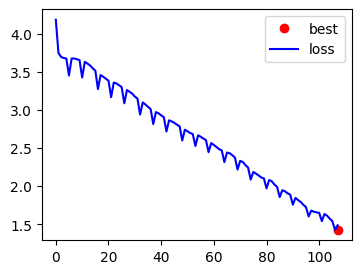

Best epoch so far:  107  smallest loss: 1.4289885811183765
Time taken for the epoch 52.292 sec

Epoch 109 Batch 3 Loss: 1.0791
Epoch 109 Batch 6 Loss: 1.3300
Epoch 109 Batch 9 Loss: 1.6898
Epoch 109 Batch 12 Loss: 1.6685
Epoch 109 Batch 15 Loss: 1.1156
Epoch 109 Batch 18 Loss: 1.6758
Epoch 109 Batch 21 Loss: 1.0714
Epoch 109 Batch 24 Loss: 1.4814

*** Epoch 109 Loss 1.4652 ***

Best epoch so far:  107  smallest loss: 1.4289885811183765
Time taken for the epoch 50.566 sec

Epoch 110 Batch 3 Loss: 1.0618
Epoch 110 Batch 6 Loss: 1.1818
Epoch 110 Batch 9 Loss: 1.6163
Epoch 110 Batch 12 Loss: 1.4974
Epoch 110 Batch 15 Loss: 1.1046
Epoch 110 Batch 18 Loss: 1.6511
Epoch 110 Batch 21 Loss: 1.1211
Epoch 110 Batch 24 Loss: 1.3242

*** Epoch 110 Loss 1.4380 ***

Best epoch so far:  107  smallest loss: 1.4289885811183765
Time taken for the epoch 51.182 sec

Epoch 111 Batch 3 Loss: 1.0572
Epoch 111 Batch 6 Loss: 1.0449
Epoch 111 Batch 9 Loss: 1.4899
Epoch 111 Batch 12 Loss: 1.4733
Epoch 111 Batch 1

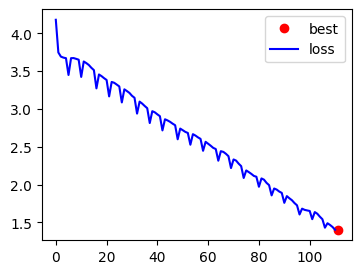

Best epoch so far:  111  smallest loss: 1.4011799356211787
Time taken for the epoch 51.237 sec

Epoch 112 Batch 3 Loss: 1.1291
Epoch 112 Batch 6 Loss: 0.9820
Epoch 112 Batch 9 Loss: 1.4988
Epoch 112 Batch 12 Loss: 1.5698
Epoch 112 Batch 15 Loss: 1.0782
Epoch 112 Batch 18 Loss: 1.4769
Epoch 112 Batch 21 Loss: 1.4397
Epoch 112 Batch 24 Loss: 1.6584

*** Epoch 112 Loss 1.3746 ***

check point saved!
Best epoch so far:  112  smallest loss: 1.3745959738026494
Time taken for the epoch 51.731 sec

Epoch 113 Batch 3 Loss: 1.2083
Epoch 113 Batch 6 Loss: 1.1054
Epoch 113 Batch 9 Loss: 1.4409
Epoch 113 Batch 12 Loss: 1.5673
Epoch 113 Batch 15 Loss: 1.0524
Epoch 113 Batch 18 Loss: 1.3364
Epoch 113 Batch 21 Loss: 1.3669
Epoch 113 Batch 24 Loss: 1.7054

*** Epoch 113 Loss 1.2668 ***

check point saved!
Best epoch so far:  113  smallest loss: 1.2667869070301885
Time taken for the epoch 48.444 sec

Epoch 114 Batch 3 Loss: 1.0174
Epoch 114 Batch 6 Loss: 1.2499
Epoch 114 Batch 9 Loss: 1.5210
Epoch 114 B

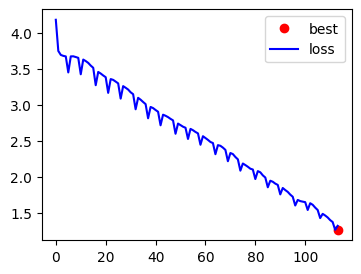

Best epoch so far:  113  smallest loss: 1.2667869070301885
Time taken for the epoch 51.401 sec

Epoch 115 Batch 3 Loss: 0.9512
Epoch 115 Batch 6 Loss: 1.0896
Epoch 115 Batch 9 Loss: 1.4597
Epoch 115 Batch 12 Loss: 1.4059
Epoch 115 Batch 15 Loss: 0.9574
Epoch 115 Batch 18 Loss: 1.4557
Epoch 115 Batch 21 Loss: 0.9624
Epoch 115 Batch 24 Loss: 1.2399

*** Epoch 115 Loss 1.2979 ***

Best epoch so far:  113  smallest loss: 1.2667869070301885
Time taken for the epoch 52.507 sec

Epoch 116 Batch 3 Loss: 0.9155
Epoch 116 Batch 6 Loss: 0.9417
Epoch 116 Batch 9 Loss: 1.3762
Epoch 116 Batch 12 Loss: 1.3151
Epoch 116 Batch 15 Loss: 0.9525
Epoch 116 Batch 18 Loss: 1.4340
Epoch 116 Batch 21 Loss: 1.1532
Epoch 116 Batch 24 Loss: 1.3305

*** Epoch 116 Loss 1.2851 ***

Best epoch so far:  113  smallest loss: 1.2667869070301885
Time taken for the epoch 51.612 sec

Epoch 117 Batch 3 Loss: 1.0490
Epoch 117 Batch 6 Loss: 0.9006
Epoch 117 Batch 9 Loss: 1.4132
Epoch 117 Batch 12 Loss: 1.4849
Epoch 117 Batch 1

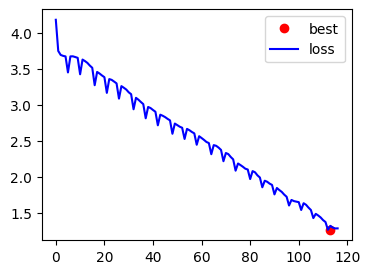

Best epoch so far:  113  smallest loss: 1.2667869070301885
Time taken for the epoch 53.248 sec

Epoch 118 Batch 3 Loss: 1.0997
Epoch 118 Batch 6 Loss: 0.9396
Epoch 118 Batch 9 Loss: 1.4486
Epoch 118 Batch 12 Loss: 1.4941
Epoch 118 Batch 15 Loss: 0.9966
Epoch 118 Batch 18 Loss: 1.2863
Epoch 118 Batch 21 Loss: 1.3349
Epoch 118 Batch 24 Loss: 1.6484

*** Epoch 118 Loss 1.2142 ***

check point saved!
Best epoch so far:  118  smallest loss: 1.21417062178902
Time taken for the epoch 48.226 sec

Epoch 119 Batch 3 Loss: 0.9806
Epoch 119 Batch 6 Loss: 1.2294
Epoch 119 Batch 9 Loss: 1.5124
Epoch 119 Batch 12 Loss: 1.4223
Epoch 119 Batch 15 Loss: 0.9572
Epoch 119 Batch 18 Loss: 1.5652
Epoch 119 Batch 21 Loss: 0.7560
Epoch 119 Batch 24 Loss: 1.3604

*** Epoch 119 Loss 1.2757 ***

Best epoch so far:  118  smallest loss: 1.21417062178902
Time taken for the epoch 50.876 sec

Epoch 120 Batch 3 Loss: 0.9029
Epoch 120 Batch 6 Loss: 1.0978
Epoch 120 Batch 9 Loss: 1.4186
Epoch 120 Batch 12 Loss: 1.3820
Ep

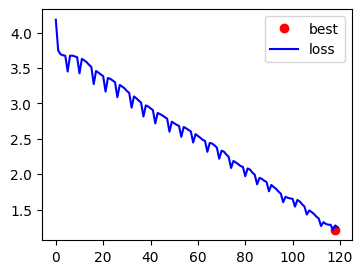

Best epoch so far:  118  smallest loss: 1.21417062178902
Time taken for the epoch 51.830 sec

Epoch 121 Batch 3 Loss: 0.8355
Epoch 121 Batch 6 Loss: 0.9192
Epoch 121 Batch 9 Loss: 1.3371
Epoch 121 Batch 12 Loss: 1.2719
Epoch 121 Batch 15 Loss: 0.8742
Epoch 121 Batch 18 Loss: 1.4572
Epoch 121 Batch 21 Loss: 1.0236
Epoch 121 Batch 24 Loss: 1.1522

*** Epoch 121 Loss 1.2144 ***

Best epoch so far:  118  smallest loss: 1.21417062178902
Time taken for the epoch 51.320 sec

Epoch 122 Batch 3 Loss: 0.9499
Epoch 122 Batch 6 Loss: 0.8386
Epoch 122 Batch 9 Loss: 1.2755
Epoch 122 Batch 12 Loss: 1.2966
Epoch 122 Batch 15 Loss: 0.8473
Epoch 122 Batch 18 Loss: 1.2738
Epoch 122 Batch 21 Loss: 1.1521
Epoch 122 Batch 24 Loss: 1.3405

*** Epoch 122 Loss 1.1858 ***

check point saved!
Best epoch so far:  122  smallest loss: 1.185830240664275
Time taken for the epoch 55.244 sec

Epoch 123 Batch 3 Loss: 1.0039
Epoch 123 Batch 6 Loss: 0.8449
Epoch 123 Batch 9 Loss: 1.2849
Epoch 123 Batch 12 Loss: 1.2820
Epo

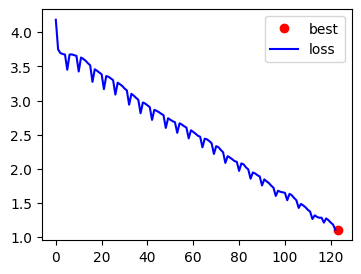

Best epoch so far:  123  smallest loss: 1.1094779968261719
Time taken for the epoch 53.536 sec

Epoch 124 Batch 3 Loss: 0.8858
Epoch 124 Batch 6 Loss: 1.1520
Epoch 124 Batch 9 Loss: 1.3700
Epoch 124 Batch 12 Loss: 1.3136
Epoch 124 Batch 15 Loss: 0.8911
Epoch 124 Batch 18 Loss: 1.4693
Epoch 124 Batch 21 Loss: 0.7138
Epoch 124 Batch 24 Loss: 1.2208

*** Epoch 124 Loss 1.1781 ***

Best epoch so far:  123  smallest loss: 1.1094779968261719
Time taken for the epoch 52.233 sec

Epoch 125 Batch 3 Loss: 0.8514
Epoch 125 Batch 6 Loss: 1.0381
Epoch 125 Batch 9 Loss: 1.3317
Epoch 125 Batch 12 Loss: 1.3267
Epoch 125 Batch 15 Loss: 0.8530
Epoch 125 Batch 18 Loss: 1.4022
Epoch 125 Batch 21 Loss: 0.9049
Epoch 125 Batch 24 Loss: 1.2184

*** Epoch 125 Loss 1.1767 ***

Best epoch so far:  123  smallest loss: 1.1094779968261719
Time taken for the epoch 51.824 sec

Epoch 126 Batch 3 Loss: 0.8394
Epoch 126 Batch 6 Loss: 0.9426
Epoch 126 Batch 9 Loss: 1.3685
Epoch 126 Batch 12 Loss: 1.2541
Epoch 126 Batch 1

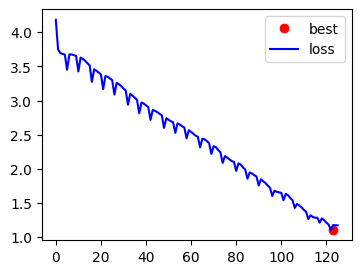

Best epoch so far:  123  smallest loss: 1.1094779968261719
Time taken for the epoch 52.867 sec

Epoch 127 Batch 3 Loss: 0.8652
Epoch 127 Batch 6 Loss: 0.8157
Epoch 127 Batch 9 Loss: 1.3086
Epoch 127 Batch 12 Loss: 1.2358
Epoch 127 Batch 15 Loss: 0.7836
Epoch 127 Batch 18 Loss: 1.2021
Epoch 127 Batch 21 Loss: 1.1084
Epoch 127 Batch 24 Loss: 1.3299

*** Epoch 127 Loss 1.1623 ***

Best epoch so far:  123  smallest loss: 1.1094779968261719
Time taken for the epoch 51.056 sec

Epoch 128 Batch 3 Loss: 0.9470
Epoch 128 Batch 6 Loss: 0.7430
Epoch 128 Batch 9 Loss: 1.2995
Epoch 128 Batch 12 Loss: 1.3647
Epoch 128 Batch 15 Loss: 0.8793
Epoch 128 Batch 18 Loss: 1.1993
Epoch 128 Batch 21 Loss: 1.1994
Epoch 128 Batch 24 Loss: 1.3533

*** Epoch 128 Loss 1.1380 ***

Best epoch so far:  123  smallest loss: 1.1094779968261719
Time taken for the epoch 52.794 sec

Epoch 129 Batch 3 Loss: 1.0008
Epoch 129 Batch 6 Loss: 0.8756
Epoch 129 Batch 9 Loss: 1.1670
Epoch 129 Batch 12 Loss: 1.2711
Epoch 129 Batch 1

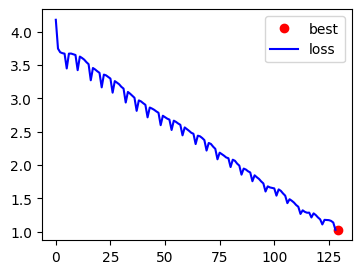

Best epoch so far:  129  smallest loss: 1.0292448790177056
Time taken for the epoch 46.347 sec

Epoch 130 Batch 3 Loss: 0.8159
Epoch 130 Batch 6 Loss: 1.0005
Epoch 130 Batch 9 Loss: 1.2609
Epoch 130 Batch 12 Loss: 1.1732
Epoch 130 Batch 15 Loss: 0.7492
Epoch 130 Batch 18 Loss: 1.2855
Epoch 130 Batch 21 Loss: 0.6990
Epoch 130 Batch 24 Loss: 1.1078

*** Epoch 130 Loss 1.0598 ***

Best epoch so far:  129  smallest loss: 1.0292448790177056
Time taken for the epoch 49.424 sec

Epoch 131 Batch 3 Loss: 0.7376
Epoch 131 Batch 6 Loss: 0.8407
Epoch 131 Batch 9 Loss: 1.2009
Epoch 131 Batch 12 Loss: 1.1672
Epoch 131 Batch 15 Loss: 0.7244
Epoch 131 Batch 18 Loss: 1.1502
Epoch 131 Batch 21 Loss: 0.7521
Epoch 131 Batch 24 Loss: 0.9832

*** Epoch 131 Loss 1.0252 ***

check point saved!
Best epoch so far:  131  smallest loss: 1.0252311540686565
Time taken for the epoch 50.446 sec

Epoch 132 Batch 3 Loss: 0.6945
Epoch 132 Batch 6 Loss: 0.6913
Epoch 132 Batch 9 Loss: 1.0741
Epoch 132 Batch 12 Loss: 1.045

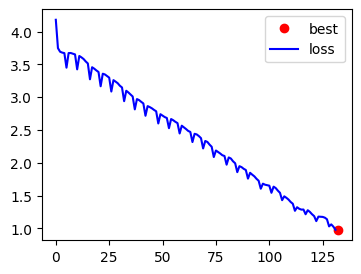

Best epoch so far:  132  smallest loss: 0.9773737036663553
Time taken for the epoch 52.191 sec

Epoch 133 Batch 3 Loss: 0.8045
Epoch 133 Batch 6 Loss: 0.6444
Epoch 133 Batch 9 Loss: 1.1118
Epoch 133 Batch 12 Loss: 1.0914
Epoch 133 Batch 15 Loss: 0.7279
Epoch 133 Batch 18 Loss: 1.0528
Epoch 133 Batch 21 Loss: 0.9363
Epoch 133 Batch 24 Loss: 1.1007

*** Epoch 133 Loss 0.9529 ***

check point saved!
Best epoch so far:  133  smallest loss: 0.9529237332551376
Time taken for the epoch 51.756 sec

Epoch 134 Batch 3 Loss: 0.7950
Epoch 134 Batch 6 Loss: 0.6889
Epoch 134 Batch 9 Loss: 1.0911
Epoch 134 Batch 12 Loss: 1.0581
Epoch 134 Batch 15 Loss: 0.6878
Epoch 134 Batch 18 Loss: 0.9519
Epoch 134 Batch 21 Loss: 1.0038
Epoch 134 Batch 24 Loss: 1.1477

*** Epoch 134 Loss 0.8809 ***

check point saved!
Best epoch so far:  134  smallest loss: 0.8809165954589844
Time taken for the epoch 48.774 sec

Epoch 135 Batch 3 Loss: 0.6850
Epoch 135 Batch 6 Loss: 0.8526
Epoch 135 Batch 9 Loss: 1.0991
Epoch 135 B

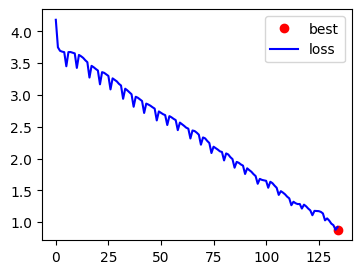

Best epoch so far:  134  smallest loss: 0.8809165954589844
Time taken for the epoch 49.500 sec

Epoch 136 Batch 3 Loss: 0.6634
Epoch 136 Batch 6 Loss: 0.7458
Epoch 136 Batch 9 Loss: 1.0343
Epoch 136 Batch 12 Loss: 1.0574
Epoch 136 Batch 15 Loss: 0.6297
Epoch 136 Batch 18 Loss: 1.0301
Epoch 136 Batch 21 Loss: 0.6485
Epoch 136 Batch 24 Loss: 0.8954

*** Epoch 136 Loss 0.9221 ***

Best epoch so far:  134  smallest loss: 0.8809165954589844
Time taken for the epoch 50.522 sec

Epoch 137 Batch 3 Loss: 0.6273
Epoch 137 Batch 6 Loss: 0.6777
Epoch 137 Batch 9 Loss: 1.0185
Epoch 137 Batch 12 Loss: 0.9493
Epoch 137 Batch 15 Loss: 0.6319
Epoch 137 Batch 18 Loss: 1.0719
Epoch 137 Batch 21 Loss: 0.7626
Epoch 137 Batch 24 Loss: 0.8650

*** Epoch 137 Loss 0.9034 ***

Best epoch so far:  134  smallest loss: 0.8809165954589844
Time taken for the epoch 50.031 sec

Epoch 138 Batch 3 Loss: 0.6763
Epoch 138 Batch 6 Loss: 0.5980
Epoch 138 Batch 9 Loss: 0.9963
Epoch 138 Batch 12 Loss: 1.0143
Epoch 138 Batch 1

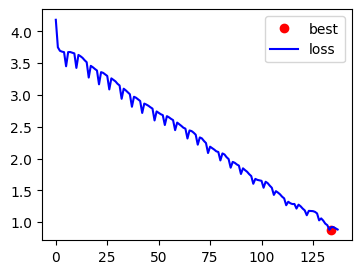

Best epoch so far:  134  smallest loss: 0.8809165954589844
Time taken for the epoch 52.707 sec

Epoch 139 Batch 3 Loss: 0.7313
Epoch 139 Batch 6 Loss: 0.5719
Epoch 139 Batch 9 Loss: 0.9686
Epoch 139 Batch 12 Loss: 1.0069
Epoch 139 Batch 15 Loss: 0.6779
Epoch 139 Batch 18 Loss: 0.9369
Epoch 139 Batch 21 Loss: 0.9101
Epoch 139 Batch 24 Loss: 1.0872

*** Epoch 139 Loss 0.8260 ***

check point saved!
Best epoch so far:  139  smallest loss: 0.8260318921959918
Time taken for the epoch 48.877 sec

Epoch 140 Batch 3 Loss: 0.6535
Epoch 140 Batch 6 Loss: 0.8298
Epoch 140 Batch 9 Loss: 1.0249
Epoch 140 Batch 12 Loss: 0.9919
Epoch 140 Batch 15 Loss: 0.6298
Epoch 140 Batch 18 Loss: 1.0928
Epoch 140 Batch 21 Loss: 0.5201
Epoch 140 Batch 24 Loss: 0.8871

*** Epoch 140 Loss 0.8678 ***

Best epoch so far:  139  smallest loss: 0.8260318921959918
Time taken for the epoch 49.759 sec

Epoch 141 Batch 3 Loss: 0.6452
Epoch 141 Batch 6 Loss: 0.7591
Epoch 141 Batch 9 Loss: 0.9742
Epoch 141 Batch 12 Loss: 0.974

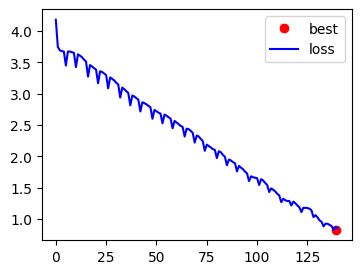

Best epoch so far:  139  smallest loss: 0.8260318921959918
Time taken for the epoch 51.790 sec

Epoch 142 Batch 3 Loss: 0.6214
Epoch 142 Batch 6 Loss: 0.6963
Epoch 142 Batch 9 Loss: 0.9732
Epoch 142 Batch 12 Loss: 0.8894
Epoch 142 Batch 15 Loss: 0.5558
Epoch 142 Batch 18 Loss: 0.9351
Epoch 142 Batch 21 Loss: 0.6812
Epoch 142 Batch 24 Loss: 0.7879

*** Epoch 142 Loss 0.8344 ***

Best epoch so far:  139  smallest loss: 0.8260318921959918
Time taken for the epoch 49.978 sec

Epoch 143 Batch 3 Loss: 0.5888
Epoch 143 Batch 6 Loss: 0.5706
Epoch 143 Batch 9 Loss: 0.8686
Epoch 143 Batch 12 Loss: 0.8732
Epoch 143 Batch 15 Loss: 0.5204
Epoch 143 Batch 18 Loss: 0.8323
Epoch 143 Batch 21 Loss: 0.7616
Epoch 143 Batch 24 Loss: 0.9195

*** Epoch 143 Loss 0.8022 ***

check point saved!
Best epoch so far:  143  smallest loss: 0.8021799170452616
Time taken for the epoch 52.069 sec

Epoch 144 Batch 3 Loss: 0.6368
Epoch 144 Batch 6 Loss: 0.5130
Epoch 144 Batch 9 Loss: 0.8928
Epoch 144 Batch 12 Loss: 0.930

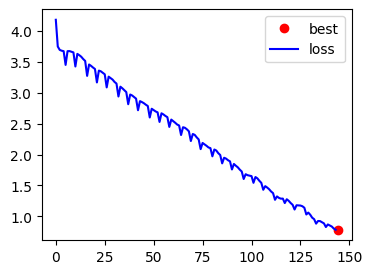

Best epoch so far:  144  smallest loss: 0.7815149556035581
Time taken for the epoch 51.218 sec

Epoch 145 Batch 3 Loss: 0.6441
Epoch 145 Batch 6 Loss: 0.5891
Epoch 145 Batch 9 Loss: 0.8625
Epoch 145 Batch 12 Loss: 0.9194
Epoch 145 Batch 15 Loss: 0.5673
Epoch 145 Batch 18 Loss: 0.7850
Epoch 145 Batch 21 Loss: 0.7838
Epoch 145 Batch 24 Loss: 0.9819

*** Epoch 145 Loss 0.7156 ***

check point saved!
Best epoch so far:  145  smallest loss: 0.7155659717062245
Time taken for the epoch 49.531 sec

Epoch 146 Batch 3 Loss: 0.5570
Epoch 146 Batch 6 Loss: 0.6670
Epoch 146 Batch 9 Loss: 0.8727
Epoch 146 Batch 12 Loss: 0.8653
Epoch 146 Batch 15 Loss: 0.5293
Epoch 146 Batch 18 Loss: 0.9314
Epoch 146 Batch 21 Loss: 0.4845
Epoch 146 Batch 24 Loss: 0.7811

*** Epoch 146 Loss 0.7470 ***

Best epoch so far:  145  smallest loss: 0.7155659717062245
Time taken for the epoch 52.331 sec

Epoch 147 Batch 3 Loss: 0.5702
Epoch 147 Batch 6 Loss: 0.6177
Epoch 147 Batch 9 Loss: 0.8657
Epoch 147 Batch 12 Loss: 0.793

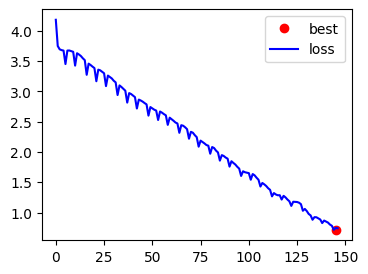

Best epoch so far:  145  smallest loss: 0.7155659717062245
Time taken for the epoch 53.463 sec

Epoch 148 Batch 3 Loss: 0.5278
Epoch 148 Batch 6 Loss: 0.5389
Epoch 148 Batch 9 Loss: 0.7928
Epoch 148 Batch 12 Loss: 0.7730
Epoch 148 Batch 15 Loss: 0.4851
Epoch 148 Batch 18 Loss: 0.8226
Epoch 148 Batch 21 Loss: 0.6563
Epoch 148 Batch 24 Loss: 0.7410

*** Epoch 148 Loss 0.7257 ***

Best epoch so far:  145  smallest loss: 0.7155659717062245
Time taken for the epoch 51.633 sec

Epoch 149 Batch 3 Loss: 0.5739
Epoch 149 Batch 6 Loss: 0.4724
Epoch 149 Batch 9 Loss: 0.8284
Epoch 149 Batch 12 Loss: 0.8598
Epoch 149 Batch 15 Loss: 0.5003
Epoch 149 Batch 18 Loss: 0.7872
Epoch 149 Batch 21 Loss: 0.7272
Epoch 149 Batch 24 Loss: 0.8651

*** Epoch 149 Loss 0.7178 ***

Best epoch so far:  145  smallest loss: 0.7155659717062245
Time taken for the epoch 52.591 sec

Epoch 150 Batch 3 Loss: 0.5838
Epoch 150 Batch 6 Loss: 0.4857
Epoch 150 Batch 9 Loss: 0.8570
Epoch 150 Batch 12 Loss: 0.8294
Epoch 150 Batch 1

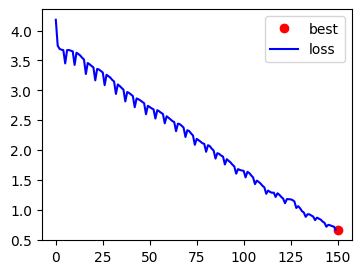

Best epoch so far:  150  smallest loss: 0.6643992299618928
Time taken for the epoch 49.724 sec

Epoch 151 Batch 3 Loss: 0.5193
Epoch 151 Batch 6 Loss: 0.6167
Epoch 151 Batch 9 Loss: 0.8182
Epoch 151 Batch 12 Loss: 0.8664
Epoch 151 Batch 15 Loss: 0.4884
Epoch 151 Batch 18 Loss: 0.8490
Epoch 151 Batch 21 Loss: 0.3920
Epoch 151 Batch 24 Loss: 0.7434

*** Epoch 151 Loss 0.6967 ***

Best epoch so far:  150  smallest loss: 0.6643992299618928
Time taken for the epoch 52.347 sec

Epoch 152 Batch 3 Loss: 0.4949
Epoch 152 Batch 6 Loss: 0.5615
Epoch 152 Batch 9 Loss: 0.8097
Epoch 152 Batch 12 Loss: 0.7733
Epoch 152 Batch 15 Loss: 0.4334
Epoch 152 Batch 18 Loss: 0.7618
Epoch 152 Batch 21 Loss: 0.4846
Epoch 152 Batch 24 Loss: 0.6744

*** Epoch 152 Loss 0.6875 ***

Best epoch so far:  150  smallest loss: 0.6643992299618928
Time taken for the epoch 52.170 sec

Epoch 153 Batch 3 Loss: 0.4459
Epoch 153 Batch 6 Loss: 0.4999
Epoch 153 Batch 9 Loss: 0.8438
Epoch 153 Batch 12 Loss: 0.7249
Epoch 153 Batch 1

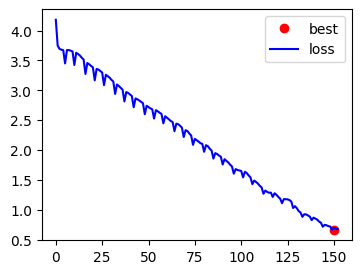

Best epoch so far:  150  smallest loss: 0.6643992299618928
Time taken for the epoch 53.360 sec

Epoch 154 Batch 3 Loss: 0.4896
Epoch 154 Batch 6 Loss: 0.4234
Epoch 154 Batch 9 Loss: 0.7424
Epoch 154 Batch 12 Loss: 0.7418
Epoch 154 Batch 15 Loss: 0.4394
Epoch 154 Batch 18 Loss: 0.7055
Epoch 154 Batch 21 Loss: 0.6080
Epoch 154 Batch 24 Loss: 0.7338

*** Epoch 154 Loss 0.6461 ***

check point saved!
Best epoch so far:  154  smallest loss: 0.646063348521357
Time taken for the epoch 51.936 sec

Epoch 155 Batch 3 Loss: 0.5124
Epoch 155 Batch 6 Loss: 0.3940
Epoch 155 Batch 9 Loss: 0.7223
Epoch 155 Batch 12 Loss: 0.6824
Epoch 155 Batch 15 Loss: 0.4550
Epoch 155 Batch 18 Loss: 0.6675
Epoch 155 Batch 21 Loss: 0.6219
Epoch 155 Batch 24 Loss: 0.7371

*** Epoch 155 Loss 0.5760 ***

check point saved!
Best epoch so far:  155  smallest loss: 0.5759950306104578
Time taken for the epoch 50.515 sec

Epoch 156 Batch 3 Loss: 0.4372
Epoch 156 Batch 6 Loss: 0.5522
Epoch 156 Batch 9 Loss: 0.7018
Epoch 156 Ba

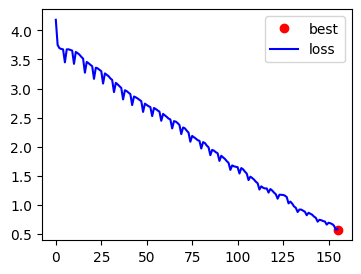

Best epoch so far:  155  smallest loss: 0.5759950306104578
Time taken for the epoch 52.505 sec

Epoch 157 Batch 3 Loss: 0.4132
Epoch 157 Batch 6 Loss: 0.4821
Epoch 157 Batch 9 Loss: 0.6798
Epoch 157 Batch 12 Loss: 0.6770
Epoch 157 Batch 15 Loss: 0.3678
Epoch 157 Batch 18 Loss: 0.6784
Epoch 157 Batch 21 Loss: 0.4034
Epoch 157 Batch 24 Loss: 0.5754

*** Epoch 157 Loss 0.5683 ***

check point saved!
Best epoch so far:  157  smallest loss: 0.568268402763035
Time taken for the epoch 52.395 sec

Epoch 158 Batch 3 Loss: 0.4157
Epoch 158 Batch 6 Loss: 0.4285
Epoch 158 Batch 9 Loss: 0.6816
Epoch 158 Batch 12 Loss: 0.6324
Epoch 158 Batch 15 Loss: 0.3478
Epoch 158 Batch 18 Loss: 0.6166
Epoch 158 Batch 21 Loss: 0.4294
Epoch 158 Batch 24 Loss: 0.5102

*** Epoch 158 Loss 0.5489 ***

check point saved!
Best epoch so far:  158  smallest loss: 0.5489460489024287
Time taken for the epoch 51.533 sec

Epoch 159 Batch 3 Loss: 0.3969
Epoch 159 Batch 6 Loss: 0.3706
Epoch 159 Batch 9 Loss: 0.6367
Epoch 159 Ba

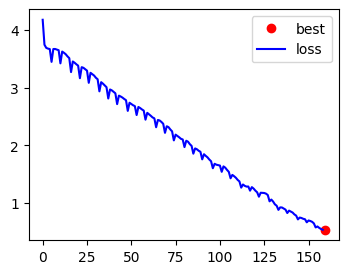

Best epoch so far:  159  smallest loss: 0.5352237120918606
Time taken for the epoch 52.606 sec

Epoch 160 Batch 3 Loss: 0.4182
Epoch 160 Batch 6 Loss: 0.3416
Epoch 160 Batch 9 Loss: 0.6375
Epoch 160 Batch 12 Loss: 0.6050
Epoch 160 Batch 15 Loss: 0.3490
Epoch 160 Batch 18 Loss: 0.5851
Epoch 160 Batch 21 Loss: 0.5444
Epoch 160 Batch 24 Loss: 0.6347

*** Epoch 160 Loss 0.5225 ***

check point saved!
Best epoch so far:  160  smallest loss: 0.5225433266681173
Time taken for the epoch 51.091 sec

Epoch 161 Batch 3 Loss: 0.4207
Epoch 161 Batch 6 Loss: 0.3784
Epoch 161 Batch 9 Loss: 0.6059
Epoch 161 Batch 12 Loss: 0.6104
Epoch 161 Batch 15 Loss: 0.3707
Epoch 161 Batch 18 Loss: 0.5422
Epoch 161 Batch 21 Loss: 0.4900
Epoch 161 Batch 24 Loss: 0.6819

*** Epoch 161 Loss 0.4756 ***

check point saved!
Best epoch so far:  161  smallest loss: 0.4755555443141771
Time taken for the epoch 48.209 sec

Epoch 162 Batch 3 Loss: 0.3749
Epoch 162 Batch 6 Loss: 0.4507
Epoch 162 Batch 9 Loss: 0.6247
Epoch 162 B

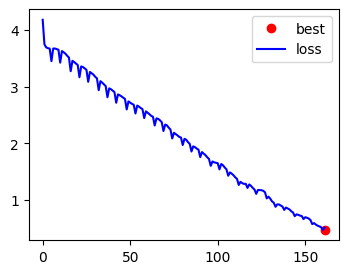

Best epoch so far:  161  smallest loss: 0.4755555443141771
Time taken for the epoch 52.149 sec

Epoch 163 Batch 3 Loss: 0.3628
Epoch 163 Batch 6 Loss: 0.3998
Epoch 163 Batch 9 Loss: 0.6294
Epoch 163 Batch 12 Loss: 0.5708
Epoch 163 Batch 15 Loss: 0.3096
Epoch 163 Batch 18 Loss: 0.5693
Epoch 163 Batch 21 Loss: 0.3546
Epoch 163 Batch 24 Loss: 0.5087

*** Epoch 163 Loss 0.4994 ***

Best epoch so far:  161  smallest loss: 0.4755555443141771
Time taken for the epoch 51.759 sec

Epoch 164 Batch 3 Loss: 0.3414
Epoch 164 Batch 6 Loss: 0.3299
Epoch 164 Batch 9 Loss: 0.6292
Epoch 164 Batch 12 Loss: 0.5498
Epoch 164 Batch 15 Loss: 0.3022
Epoch 164 Batch 18 Loss: 0.5353
Epoch 164 Batch 21 Loss: 0.4135
Epoch 164 Batch 24 Loss: 0.5038

*** Epoch 164 Loss 0.4888 ***

Best epoch so far:  161  smallest loss: 0.4755555443141771
Time taken for the epoch 50.264 sec

Epoch 165 Batch 3 Loss: 0.3933
Epoch 165 Batch 6 Loss: 0.2997
Epoch 165 Batch 9 Loss: 0.6241
Epoch 165 Batch 12 Loss: 0.5810
Epoch 165 Batch 1

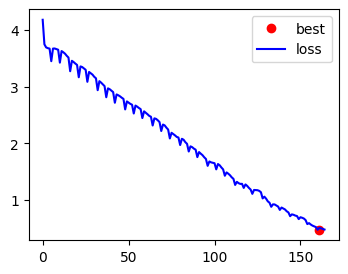

Best epoch so far:  161  smallest loss: 0.4755555443141771
Time taken for the epoch 52.854 sec

Epoch 166 Batch 3 Loss: 0.3881
Epoch 166 Batch 6 Loss: 0.3124
Epoch 166 Batch 9 Loss: 0.5898
Epoch 166 Batch 12 Loss: 0.5076
Epoch 166 Batch 15 Loss: 0.3119
Epoch 166 Batch 18 Loss: 0.4902
Epoch 166 Batch 21 Loss: 0.4700
Epoch 166 Batch 24 Loss: 0.5557

*** Epoch 166 Loss 0.4301 ***

check point saved!
Best epoch so far:  166  smallest loss: 0.43005333776059357
Time taken for the epoch 48.008 sec

Epoch 167 Batch 3 Loss: 0.3235
Epoch 167 Batch 6 Loss: 0.3947
Epoch 167 Batch 9 Loss: 0.6042
Epoch 167 Batch 12 Loss: 0.5605
Epoch 167 Batch 15 Loss: 0.3132
Epoch 167 Batch 18 Loss: 0.5718
Epoch 167 Batch 21 Loss: 0.2554
Epoch 167 Batch 24 Loss: 0.5231

*** Epoch 167 Loss 0.4629 ***

Best epoch so far:  166  smallest loss: 0.43005333776059357
Time taken for the epoch 50.353 sec

Epoch 168 Batch 3 Loss: 0.3282
Epoch 168 Batch 6 Loss: 0.3454
Epoch 168 Batch 9 Loss: 0.5621
Epoch 168 Batch 12 Loss: 0.5

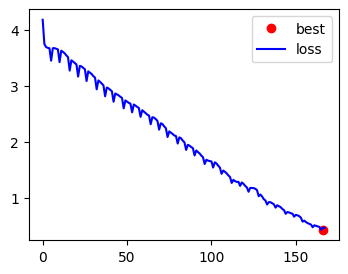

Best epoch so far:  166  smallest loss: 0.43005333776059357
Time taken for the epoch 51.502 sec

Epoch 169 Batch 3 Loss: 0.3334
Epoch 169 Batch 6 Loss: 0.3369
Epoch 169 Batch 9 Loss: 0.5759
Epoch 169 Batch 12 Loss: 0.4805
Epoch 169 Batch 15 Loss: 0.2900
Epoch 169 Batch 18 Loss: 0.5726
Epoch 169 Batch 21 Loss: 0.3745
Epoch 169 Batch 24 Loss: 0.4486

*** Epoch 169 Loss 0.4627 ***

Best epoch so far:  166  smallest loss: 0.43005333776059357
Time taken for the epoch 49.327 sec

Epoch 170 Batch 3 Loss: 0.3327
Epoch 170 Batch 6 Loss: 0.3085
Epoch 170 Batch 9 Loss: 0.6301
Epoch 170 Batch 12 Loss: 0.5165
Epoch 170 Batch 15 Loss: 0.2768
Epoch 170 Batch 18 Loss: 0.5055
Epoch 170 Batch 21 Loss: 0.4729
Epoch 170 Batch 24 Loss: 0.5721

*** Epoch 170 Loss 0.4749 ***

Best epoch so far:  166  smallest loss: 0.43005333776059357
Time taken for the epoch 49.559 sec

Epoch 171 Batch 3 Loss: 0.3656
Epoch 171 Batch 6 Loss: 0.2736
Epoch 171 Batch 9 Loss: 0.5509
Epoch 171 Batch 12 Loss: 0.5485
Epoch 171 Batc

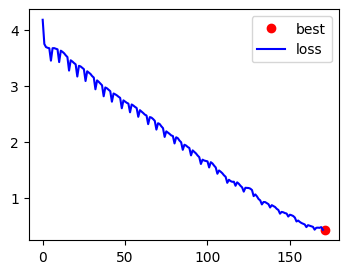

Best epoch so far:  171  smallest loss: 0.42761831698210345
Time taken for the epoch 48.835 sec

Epoch 172 Batch 3 Loss: 0.3244
Epoch 172 Batch 6 Loss: 0.4024
Epoch 172 Batch 9 Loss: 0.5418
Epoch 172 Batch 12 Loss: 0.5237
Epoch 172 Batch 15 Loss: 0.3200
Epoch 172 Batch 18 Loss: 0.5813
Epoch 172 Batch 21 Loss: 0.2440
Epoch 172 Batch 24 Loss: 0.4446

*** Epoch 172 Loss 0.4505 ***

Best epoch so far:  171  smallest loss: 0.42761831698210345
Time taken for the epoch 51.364 sec

Epoch 173 Batch 3 Loss: 0.3273
Epoch 173 Batch 6 Loss: 0.3692
Epoch 173 Batch 9 Loss: 0.5098
Epoch 173 Batch 12 Loss: 0.5134
Epoch 173 Batch 15 Loss: 0.2945
Epoch 173 Batch 18 Loss: 0.5333
Epoch 173 Batch 21 Loss: 0.2804
Epoch 173 Batch 24 Loss: 0.3965

*** Epoch 173 Loss 0.4275 ***

check point saved!
Best epoch so far:  173  smallest loss: 0.4274500971255095
Time taken for the epoch 51.966 sec

Epoch 174 Batch 3 Loss: 0.3242
Epoch 174 Batch 6 Loss: 0.3464
Epoch 174 Batch 9 Loss: 0.5366
Epoch 174 Batch 12 Loss: 0.4

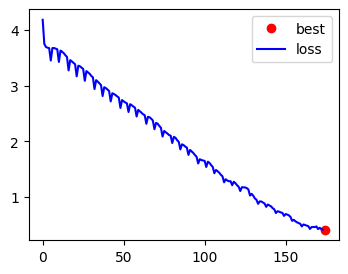

Best epoch so far:  174  smallest loss: 0.4150524968686311
Time taken for the epoch 51.604 sec

Epoch 175 Batch 3 Loss: 0.2859
Epoch 175 Batch 6 Loss: 0.2729
Epoch 175 Batch 9 Loss: 0.4833
Epoch 175 Batch 12 Loss: 0.4739
Epoch 175 Batch 15 Loss: 0.2346
Epoch 175 Batch 18 Loss: 0.4105
Epoch 175 Batch 21 Loss: 0.3485
Epoch 175 Batch 24 Loss: 0.4310

*** Epoch 175 Loss 0.3988 ***

check point saved!
Best epoch so far:  175  smallest loss: 0.3988397432410199
Time taken for the epoch 50.620 sec

Epoch 176 Batch 3 Loss: 0.3067
Epoch 176 Batch 6 Loss: 0.2428
Epoch 176 Batch 9 Loss: 0.4739
Epoch 176 Batch 12 Loss: 0.4476
Epoch 176 Batch 15 Loss: 0.2484
Epoch 176 Batch 18 Loss: 0.4272
Epoch 176 Batch 21 Loss: 0.3712
Epoch 176 Batch 24 Loss: 0.4436

*** Epoch 176 Loss 0.3845 ***

check point saved!
Best epoch so far:  176  smallest loss: 0.38450672315514606
Time taken for the epoch 49.740 sec

Epoch 177 Batch 3 Loss: 0.3164
Epoch 177 Batch 6 Loss: 0.2657
Epoch 177 Batch 9 Loss: 0.4505
Epoch 177 

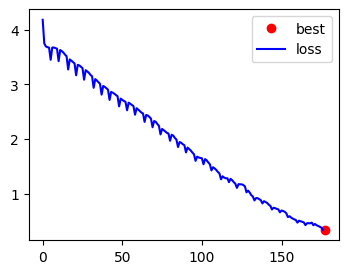

Best epoch so far:  177  smallest loss: 0.3447185806606127
Time taken for the epoch 50.324 sec

Epoch 178 Batch 3 Loss: 0.2692
Epoch 178 Batch 6 Loss: 0.3073
Epoch 178 Batch 9 Loss: 0.4654
Epoch 178 Batch 12 Loss: 0.4403
Epoch 178 Batch 15 Loss: 0.2279
Epoch 178 Batch 18 Loss: 0.4652
Epoch 178 Batch 21 Loss: 0.2111
Epoch 178 Batch 24 Loss: 0.3641

*** Epoch 178 Loss 0.3599 ***

Best epoch so far:  177  smallest loss: 0.3447185806606127
Time taken for the epoch 51.700 sec

Epoch 179 Batch 3 Loss: 0.2625
Epoch 179 Batch 6 Loss: 0.2638
Epoch 179 Batch 9 Loss: 0.4341
Epoch 179 Batch 12 Loss: 0.3995
Epoch 179 Batch 15 Loss: 0.2106
Epoch 179 Batch 18 Loss: 0.4032
Epoch 179 Batch 21 Loss: 0.2361
Epoch 179 Batch 24 Loss: 0.3221

*** Epoch 179 Loss 0.3428 ***

check point saved!
Best epoch so far:  179  smallest loss: 0.34280036843341327
Time taken for the epoch 49.907 sec

Epoch 180 Batch 3 Loss: 0.2286
Epoch 180 Batch 6 Loss: 0.2273
Epoch 180 Batch 9 Loss: 0.4107
Epoch 180 Batch 12 Loss: 0.35

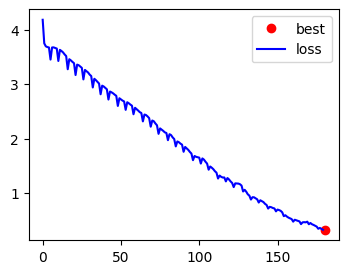

Best epoch so far:  180  smallest loss: 0.32605542307314667
Time taken for the epoch 50.678 sec

Epoch 181 Batch 3 Loss: 0.2491
Epoch 181 Batch 6 Loss: 0.1971
Epoch 181 Batch 9 Loss: 0.4124
Epoch 181 Batch 12 Loss: 0.3739
Epoch 181 Batch 15 Loss: 0.2199
Epoch 181 Batch 18 Loss: 0.3655
Epoch 181 Batch 21 Loss: 0.2743
Epoch 181 Batch 24 Loss: 0.3453

*** Epoch 181 Loss 0.3083 ***

check point saved!
Best epoch so far:  181  smallest loss: 0.3083492569301439
Time taken for the epoch 50.550 sec

Epoch 182 Batch 3 Loss: 0.2471
Epoch 182 Batch 6 Loss: 0.2139
Epoch 182 Batch 9 Loss: 0.4111
Epoch 182 Batch 12 Loss: 0.3178
Epoch 182 Batch 15 Loss: 0.1975
Epoch 182 Batch 18 Loss: 0.3212
Epoch 182 Batch 21 Loss: 0.2832
Epoch 182 Batch 24 Loss: 0.3616

*** Epoch 182 Loss 0.2742 ***

check point saved!
Best epoch so far:  182  smallest loss: 0.2741650083790655
Time taken for the epoch 49.577 sec

Epoch 183 Batch 3 Loss: 0.2108
Epoch 183 Batch 6 Loss: 0.2406
Epoch 183 Batch 9 Loss: 0.3624
Epoch 183 

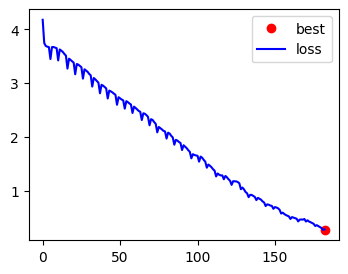

Best epoch so far:  182  smallest loss: 0.2741650083790655
Time taken for the epoch 51.648 sec

Epoch 184 Batch 3 Loss: 0.2087
Epoch 184 Batch 6 Loss: 0.2136
Epoch 184 Batch 9 Loss: 0.3465
Epoch 184 Batch 12 Loss: 0.3197
Epoch 184 Batch 15 Loss: 0.1580
Epoch 184 Batch 18 Loss: 0.3052
Epoch 184 Batch 21 Loss: 0.1700
Epoch 184 Batch 24 Loss: 0.2664

*** Epoch 184 Loss 0.2706 ***

check point saved!
Best epoch so far:  184  smallest loss: 0.27064020737357763
Time taken for the epoch 52.607 sec

Epoch 185 Batch 3 Loss: 0.1756
Epoch 185 Batch 6 Loss: 0.1778
Epoch 185 Batch 9 Loss: 0.3594
Epoch 185 Batch 12 Loss: 0.2961
Epoch 185 Batch 15 Loss: 0.1514
Epoch 185 Batch 18 Loss: 0.3080
Epoch 185 Batch 21 Loss: 0.1907
Epoch 185 Batch 24 Loss: 0.2359

*** Epoch 185 Loss 0.2571 ***

check point saved!
Best epoch so far:  185  smallest loss: 0.25705727286960767
Time taken for the epoch 49.801 sec

Epoch 186 Batch 3 Loss: 0.1833
Epoch 186 Batch 6 Loss: 0.1541
Epoch 186 Batch 9 Loss: 0.3194
Epoch 186

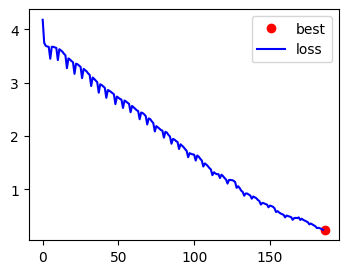

Best epoch so far:  186  smallest loss: 0.2429841083029042
Time taken for the epoch 51.641 sec

Epoch 187 Batch 3 Loss: 0.1858
Epoch 187 Batch 6 Loss: 0.1468
Epoch 187 Batch 9 Loss: 0.3157
Epoch 187 Batch 12 Loss: 0.2401
Epoch 187 Batch 15 Loss: 0.1542
Epoch 187 Batch 18 Loss: 0.2664
Epoch 187 Batch 21 Loss: 0.2284
Epoch 187 Batch 24 Loss: 0.2774

*** Epoch 187 Loss 0.2147 ***

check point saved!
Best epoch so far:  187  smallest loss: 0.21472671757573666
Time taken for the epoch 48.089 sec

Epoch 188 Batch 3 Loss: 0.1682
Epoch 188 Batch 6 Loss: 0.1975
Epoch 188 Batch 9 Loss: 0.2925
Epoch 188 Batch 12 Loss: 0.2768
Epoch 188 Batch 15 Loss: 0.1472
Epoch 188 Batch 18 Loss: 0.2638
Epoch 188 Batch 21 Loss: 0.1269
Epoch 188 Batch 24 Loss: 0.2311

*** Epoch 188 Loss 0.2253 ***

Best epoch so far:  187  smallest loss: 0.21472671757573666
Time taken for the epoch 50.083 sec

Epoch 189 Batch 3 Loss: 0.1673
Epoch 189 Batch 6 Loss: 0.1736
Epoch 189 Batch 9 Loss: 0.2844
Epoch 189 Batch 12 Loss: 0.2

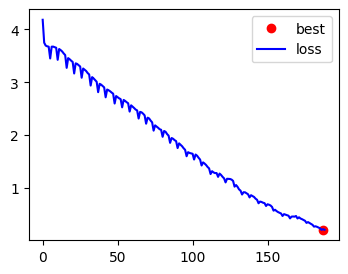

Best epoch so far:  187  smallest loss: 0.21472671757573666
Time taken for the epoch 50.356 sec

Epoch 190 Batch 3 Loss: 0.1667
Epoch 190 Batch 6 Loss: 0.1636
Epoch 190 Batch 9 Loss: 0.2935
Epoch 190 Batch 12 Loss: 0.2326
Epoch 190 Batch 15 Loss: 0.1285
Epoch 190 Batch 18 Loss: 0.2407
Epoch 190 Batch 21 Loss: 0.1463
Epoch 190 Batch 24 Loss: 0.1874

*** Epoch 190 Loss 0.2085 ***

check point saved!
Best epoch so far:  190  smallest loss: 0.20848684725554092
Time taken for the epoch 51.123 sec

Epoch 191 Batch 3 Loss: 0.1436
Epoch 191 Batch 6 Loss: 0.1388
Epoch 191 Batch 9 Loss: 0.2600
Epoch 191 Batch 12 Loss: 0.2191
Epoch 191 Batch 15 Loss: 0.1191
Epoch 191 Batch 18 Loss: 0.2214
Epoch 191 Batch 21 Loss: 0.1663
Epoch 191 Batch 24 Loss: 0.2082

*** Epoch 191 Loss 0.2009 ***

check point saved!
Best epoch so far:  191  smallest loss: 0.20090414130169412
Time taken for the epoch 51.355 sec

Epoch 192 Batch 3 Loss: 0.1535
Epoch 192 Batch 6 Loss: 0.1243
Epoch 192 Batch 9 Loss: 0.2768
Epoch 19

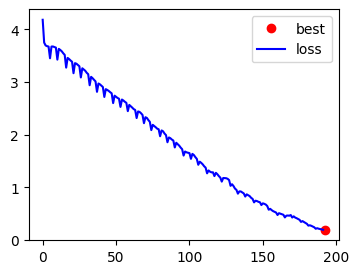

Best epoch so far:  192  smallest loss: 0.1952961424122686
Time taken for the epoch 49.394 sec

Epoch 193 Batch 3 Loss: 0.1508
Epoch 193 Batch 6 Loss: 0.1393
Epoch 193 Batch 9 Loss: 0.2555
Epoch 193 Batch 12 Loss: 0.2143
Epoch 193 Batch 15 Loss: 0.1296
Epoch 193 Batch 18 Loss: 0.2128
Epoch 193 Batch 21 Loss: 0.1717
Epoch 193 Batch 24 Loss: 0.2547

*** Epoch 193 Loss 0.1748 ***

check point saved!
Best epoch so far:  193  smallest loss: 0.17479450806327487
Time taken for the epoch 50.197 sec

Epoch 194 Batch 3 Loss: 0.1450
Epoch 194 Batch 6 Loss: 0.1559
Epoch 194 Batch 9 Loss: 0.2502
Epoch 194 Batch 12 Loss: 0.2195
Epoch 194 Batch 15 Loss: 0.1198
Epoch 194 Batch 18 Loss: 0.2266
Epoch 194 Batch 21 Loss: 0.0980
Epoch 194 Batch 24 Loss: 0.1725

*** Epoch 194 Loss 0.1830 ***

Best epoch so far:  193  smallest loss: 0.17479450806327487
Time taken for the epoch 48.463 sec

Epoch 195 Batch 3 Loss: 0.1422
Epoch 195 Batch 6 Loss: 0.1424
Epoch 195 Batch 9 Loss: 0.2490
Epoch 195 Batch 12 Loss: 0.1

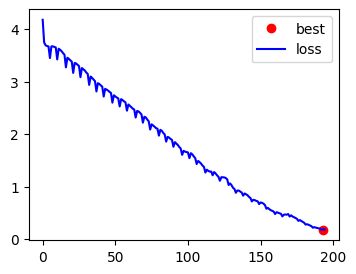

Best epoch so far:  193  smallest loss: 0.17479450806327487
Time taken for the epoch 50.033 sec

Epoch 196 Batch 3 Loss: 0.1170
Epoch 196 Batch 6 Loss: 0.1159
Epoch 196 Batch 9 Loss: 0.2520
Epoch 196 Batch 12 Loss: 0.1910
Epoch 196 Batch 15 Loss: 0.1066
Epoch 196 Batch 18 Loss: 0.1938
Epoch 196 Batch 21 Loss: 0.1339
Epoch 196 Batch 24 Loss: 0.1764

*** Epoch 196 Loss 0.1749 ***

Best epoch so far:  193  smallest loss: 0.17479450806327487
Time taken for the epoch 50.857 sec

Epoch 197 Batch 3 Loss: 0.1319
Epoch 197 Batch 6 Loss: 0.1066
Epoch 197 Batch 9 Loss: 0.2451
Epoch 197 Batch 12 Loss: 0.1900
Epoch 197 Batch 15 Loss: 0.1191
Epoch 197 Batch 18 Loss: 0.2121
Epoch 197 Batch 21 Loss: 0.1426
Epoch 197 Batch 24 Loss: 0.1761

*** Epoch 197 Loss 0.1675 ***

check point saved!
Best epoch so far:  197  smallest loss: 0.16745729031770126
Time taken for the epoch 51.696 sec

Epoch 198 Batch 3 Loss: 0.1316
Epoch 198 Batch 6 Loss: 0.1134
Epoch 198 Batch 9 Loss: 0.2564
Epoch 198 Batch 12 Loss: 0.

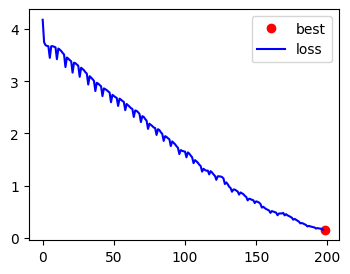

Best epoch so far:  198  smallest loss: 0.15101478410803754
Time taken for the epoch 49.850 sec

Epoch 199 Batch 3 Loss: 0.1213
Epoch 199 Batch 6 Loss: 0.1322
Epoch 199 Batch 9 Loss: 0.2245
Epoch 199 Batch 12 Loss: 0.2006
Epoch 199 Batch 15 Loss: 0.1037
Epoch 199 Batch 18 Loss: 0.1845
Epoch 199 Batch 21 Loss: 0.0780
Epoch 199 Batch 24 Loss: 0.1652

*** Epoch 199 Loss 0.1617 ***

Best epoch so far:  198  smallest loss: 0.15101478410803754
Time taken for the epoch 52.223 sec

Epoch 200 Batch 3 Loss: 0.1246
Epoch 200 Batch 6 Loss: 0.1224
Epoch 200 Batch 9 Loss: 0.2121
Epoch 200 Batch 12 Loss: 0.1734
Epoch 200 Batch 15 Loss: 0.0940
Epoch 200 Batch 18 Loss: 0.1834
Epoch 200 Batch 21 Loss: 0.0916
Epoch 200 Batch 24 Loss: 0.1493

*** Epoch 200 Loss 0.1566 ***

Best epoch so far:  198  smallest loss: 0.15101478410803754
Time taken for the epoch 51.273 sec

Epoch 201 Batch 3 Loss: 0.1008
Epoch 201 Batch 6 Loss: 0.1082
Epoch 201 Batch 9 Loss: 0.2356
Epoch 201 Batch 12 Loss: 0.1640
Epoch 201 Batc

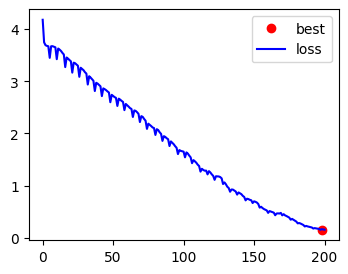

Best epoch so far:  198  smallest loss: 0.15101478410803754
Time taken for the epoch 52.937 sec

Epoch 202 Batch 3 Loss: 0.1077
Epoch 202 Batch 6 Loss: 0.0964
Epoch 202 Batch 9 Loss: 0.2337
Epoch 202 Batch 12 Loss: 0.1557
Epoch 202 Batch 15 Loss: 0.0940
Epoch 202 Batch 18 Loss: 0.1880
Epoch 202 Batch 21 Loss: 0.1246
Epoch 202 Batch 24 Loss: 0.1516

*** Epoch 202 Loss 0.1500 ***

check point saved!
Best epoch so far:  202  smallest loss: 0.15000631498253864
Time taken for the epoch 49.914 sec

Epoch 203 Batch 3 Loss: 0.1090
Epoch 203 Batch 6 Loss: 0.0912
Epoch 203 Batch 9 Loss: 0.2379
Epoch 203 Batch 12 Loss: 0.1411
Epoch 203 Batch 15 Loss: 0.0965
Epoch 203 Batch 18 Loss: 0.1677
Epoch 203 Batch 21 Loss: 0.1350
Epoch 203 Batch 24 Loss: 0.1740

*** Epoch 203 Loss 0.1338 ***

check point saved!
Best epoch so far:  203  smallest loss: 0.13380004012066385
Time taken for the epoch 50.472 sec

Epoch 204 Batch 3 Loss: 0.1094
Epoch 204 Batch 6 Loss: 0.1205
Epoch 204 Batch 9 Loss: 0.1987
Epoch 20

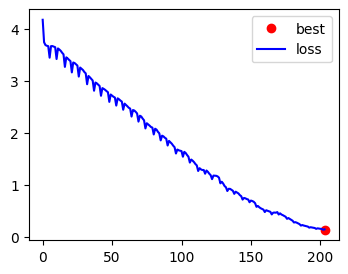

Best epoch so far:  203  smallest loss: 0.13380004012066385
Time taken for the epoch 51.506 sec

Epoch 205 Batch 3 Loss: 0.1089
Epoch 205 Batch 6 Loss: 0.1140
Epoch 205 Batch 9 Loss: 0.2261
Epoch 205 Batch 12 Loss: 0.1560
Epoch 205 Batch 15 Loss: 0.0897
Epoch 205 Batch 18 Loss: 0.1561
Epoch 205 Batch 21 Loss: 0.0871
Epoch 205 Batch 24 Loss: 0.1344

*** Epoch 205 Loss 0.1408 ***

Best epoch so far:  203  smallest loss: 0.13380004012066385
Time taken for the epoch 51.647 sec

Epoch 206 Batch 3 Loss: 0.1054
Epoch 206 Batch 6 Loss: 0.1046
Epoch 206 Batch 9 Loss: 0.2542
Epoch 206 Batch 12 Loss: 0.1537
Epoch 206 Batch 15 Loss: 0.0872
Epoch 206 Batch 18 Loss: 0.1563
Epoch 206 Batch 21 Loss: 0.0888
Epoch 206 Batch 24 Loss: 0.1249

*** Epoch 206 Loss 0.1400 ***

Best epoch so far:  203  smallest loss: 0.13380004012066385
Time taken for the epoch 52.791 sec

Epoch 207 Batch 3 Loss: 0.0972
Epoch 207 Batch 6 Loss: 0.0886
Epoch 207 Batch 9 Loss: 0.2224
Epoch 207 Batch 12 Loss: 0.1314
Epoch 207 Batc

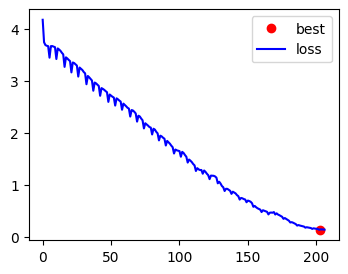

Best epoch so far:  203  smallest loss: 0.13380004012066385
Time taken for the epoch 53.304 sec

Epoch 208 Batch 3 Loss: 0.1000
Epoch 208 Batch 6 Loss: 0.0912
Epoch 208 Batch 9 Loss: 0.2685
Epoch 208 Batch 12 Loss: 0.1313
Epoch 208 Batch 15 Loss: 0.0909
Epoch 208 Batch 18 Loss: 0.1792
Epoch 208 Batch 21 Loss: 0.1346
Epoch 208 Batch 24 Loss: 0.1495

*** Epoch 208 Loss 0.1412 ***

Best epoch so far:  203  smallest loss: 0.13380004012066385
Time taken for the epoch 52.358 sec

Epoch 209 Batch 3 Loss: 0.0950
Epoch 209 Batch 6 Loss: 0.0947
Epoch 209 Batch 9 Loss: 0.2322
Epoch 209 Batch 12 Loss: 0.1546
Epoch 209 Batch 15 Loss: 0.0932
Epoch 209 Batch 18 Loss: 0.1504
Epoch 209 Batch 21 Loss: 0.1204
Epoch 209 Batch 24 Loss: 0.1880

*** Epoch 209 Loss 0.1266 ***

check point saved!
Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 47.671 sec

Epoch 210 Batch 3 Loss: 0.1103
Epoch 210 Batch 6 Loss: 0.1111
Epoch 210 Batch 9 Loss: 0.1977
Epoch 210 Batch 12 Loss: 0.1

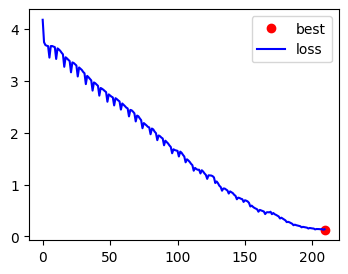

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 49.535 sec

Epoch 211 Batch 3 Loss: 0.1032
Epoch 211 Batch 6 Loss: 0.1048
Epoch 211 Batch 9 Loss: 0.2109
Epoch 211 Batch 12 Loss: 0.1414
Epoch 211 Batch 15 Loss: 0.0827
Epoch 211 Batch 18 Loss: 0.1614
Epoch 211 Batch 21 Loss: 0.0841
Epoch 211 Batch 24 Loss: 0.1312

*** Epoch 211 Loss 0.1370 ***

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 52.207 sec

Epoch 212 Batch 3 Loss: 0.0900
Epoch 212 Batch 6 Loss: 0.0898
Epoch 212 Batch 9 Loss: 0.2187
Epoch 212 Batch 12 Loss: 0.1523
Epoch 212 Batch 15 Loss: 0.0850
Epoch 212 Batch 18 Loss: 0.1527
Epoch 212 Batch 21 Loss: 0.1039
Epoch 212 Batch 24 Loss: 0.1309

*** Epoch 212 Loss 0.1378 ***

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 52.056 sec

Epoch 213 Batch 3 Loss: 0.1013
Epoch 213 Batch 6 Loss: 0.0838
Epoch 213 Batch 9 Loss: 0.2090
Epoch 213 Batch 12 Loss: 0.1541
Epoch 213 Batch 1

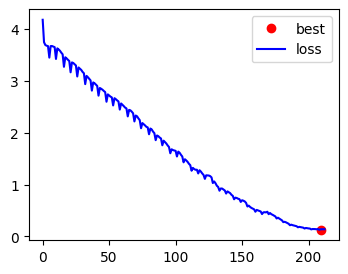

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 51.129 sec

Epoch 214 Batch 3 Loss: 0.1080
Epoch 214 Batch 6 Loss: 0.0892
Epoch 214 Batch 9 Loss: 0.2106
Epoch 214 Batch 12 Loss: 0.1387
Epoch 214 Batch 15 Loss: 0.0931
Epoch 214 Batch 18 Loss: 0.1575
Epoch 214 Batch 21 Loss: 0.1302
Epoch 214 Batch 24 Loss: 0.1648

*** Epoch 214 Loss 0.1279 ***

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 47.822 sec

Epoch 215 Batch 3 Loss: 0.1119
Epoch 215 Batch 6 Loss: 0.1461
Epoch 215 Batch 9 Loss: 0.1997
Epoch 215 Batch 12 Loss: 0.2020
Epoch 215 Batch 15 Loss: 0.0959
Epoch 215 Batch 18 Loss: 0.1612
Epoch 215 Batch 21 Loss: 0.0684
Epoch 215 Batch 24 Loss: 0.1500

*** Epoch 215 Loss 0.1445 ***

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 51.079 sec

Epoch 216 Batch 3 Loss: 0.1160
Epoch 216 Batch 6 Loss: 0.1208
Epoch 216 Batch 9 Loss: 0.1993
Epoch 216 Batch 12 Loss: 0.1660
Epoch 216 Batch 1

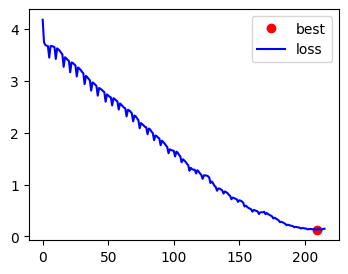

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 50.793 sec

Epoch 217 Batch 3 Loss: 0.0939
Epoch 217 Batch 6 Loss: 0.1078
Epoch 217 Batch 9 Loss: 0.2211
Epoch 217 Batch 12 Loss: 0.1531
Epoch 217 Batch 15 Loss: 0.0841
Epoch 217 Batch 18 Loss: 0.1714
Epoch 217 Batch 21 Loss: 0.1165
Epoch 217 Batch 24 Loss: 0.1378

*** Epoch 217 Loss 0.1459 ***

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 51.011 sec

Epoch 218 Batch 3 Loss: 0.1029
Epoch 218 Batch 6 Loss: 0.0846
Epoch 218 Batch 9 Loss: 0.1978
Epoch 218 Batch 12 Loss: 0.1761
Epoch 218 Batch 15 Loss: 0.0948
Epoch 218 Batch 18 Loss: 0.1724
Epoch 218 Batch 21 Loss: 0.1008
Epoch 218 Batch 24 Loss: 0.1405

*** Epoch 218 Loss 0.1401 ***

Best epoch so far:  209  smallest loss: 0.1266288653663967
Time taken for the epoch 51.306 sec

Epoch 219 Batch 3 Loss: 0.1251
Epoch 219 Batch 6 Loss: 0.0900
Epoch 219 Batch 9 Loss: 0.2047
Epoch 219 Batch 12 Loss: 0.1109
Epoch 219 Batch 1

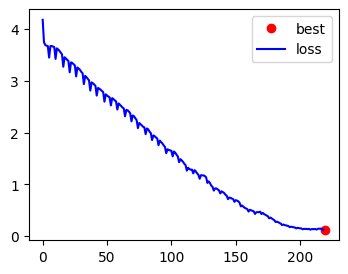

Best epoch so far:  219  smallest loss: 0.12404133962548297
Time taken for the epoch 49.967 sec

Epoch 220 Batch 3 Loss: 0.0915
Epoch 220 Batch 6 Loss: 0.1109
Epoch 220 Batch 9 Loss: 0.1761
Epoch 220 Batch 12 Loss: 0.1678
Epoch 220 Batch 15 Loss: 0.0867
Epoch 220 Batch 18 Loss: 0.1433
Epoch 220 Batch 21 Loss: 0.0698
Epoch 220 Batch 24 Loss: 0.1206

*** Epoch 220 Loss 0.1266 ***

Best epoch so far:  219  smallest loss: 0.12404133962548297
Time taken for the epoch 50.850 sec

Epoch 221 Batch 3 Loss: 0.0906
Epoch 221 Batch 6 Loss: 0.1027
Epoch 221 Batch 9 Loss: 0.1890
Epoch 221 Batch 12 Loss: 0.1370
Epoch 221 Batch 15 Loss: 0.0801
Epoch 221 Batch 18 Loss: 0.1356
Epoch 221 Batch 21 Loss: 0.0680
Epoch 221 Batch 24 Loss: 0.1074

*** Epoch 221 Loss 0.1197 ***

check point saved!
Best epoch so far:  221  smallest loss: 0.11973924222199814
Time taken for the epoch 51.456 sec

Epoch 222 Batch 3 Loss: 0.0865
Epoch 222 Batch 6 Loss: 0.0820
Epoch 222 Batch 9 Loss: 0.1824
Epoch 222 Batch 12 Loss: 0.

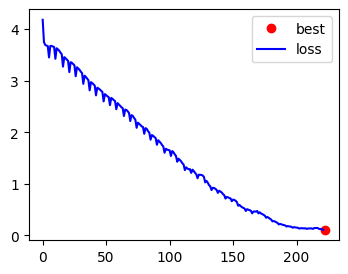

Best epoch so far:  222  smallest loss: 0.11087521262790846
Time taken for the epoch 50.857 sec

Epoch 223 Batch 3 Loss: 0.0768
Epoch 223 Batch 6 Loss: 0.0697
Epoch 223 Batch 9 Loss: 0.1611
Epoch 223 Batch 12 Loss: 0.1011
Epoch 223 Batch 15 Loss: 0.0643
Epoch 223 Batch 18 Loss: 0.1226
Epoch 223 Batch 21 Loss: 0.0719
Epoch 223 Batch 24 Loss: 0.0979

*** Epoch 223 Loss 0.1052 ***

check point saved!
Best epoch so far:  223  smallest loss: 0.10521993429764458
Time taken for the epoch 50.421 sec

Epoch 224 Batch 3 Loss: 0.0711
Epoch 224 Batch 6 Loss: 0.0614
Epoch 224 Batch 9 Loss: 0.1603
Epoch 224 Batch 12 Loss: 0.0899
Epoch 224 Batch 15 Loss: 0.0622
Epoch 224 Batch 18 Loss: 0.1223
Epoch 224 Batch 21 Loss: 0.0807
Epoch 224 Batch 24 Loss: 0.0950

*** Epoch 224 Loss 0.0956 ***

check point saved!
Best epoch so far:  224  smallest loss: 0.0955929652504299
Time taken for the epoch 53.472 sec

Epoch 225 Batch 3 Loss: 0.0645
Epoch 225 Batch 6 Loss: 0.0631
Epoch 225 Batch 9 Loss: 0.1357
Epoch 225

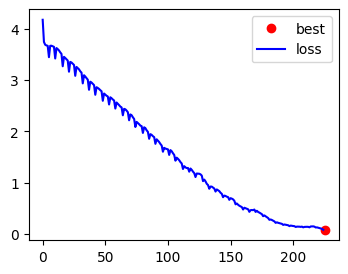

Best epoch so far:  225  smallest loss: 0.0795518626337466
Time taken for the epoch 49.308 sec

Epoch 226 Batch 3 Loss: 0.0680
Epoch 226 Batch 6 Loss: 0.0714
Epoch 226 Batch 9 Loss: 0.1322
Epoch 226 Batch 12 Loss: 0.0930
Epoch 226 Batch 15 Loss: 0.0534
Epoch 226 Batch 18 Loss: 0.0894
Epoch 226 Batch 21 Loss: 0.0386
Epoch 226 Batch 24 Loss: 0.0731

*** Epoch 226 Loss 0.0810 ***

Best epoch so far:  225  smallest loss: 0.0795518626337466
Time taken for the epoch 50.593 sec

Epoch 227 Batch 3 Loss: 0.0608
Epoch 227 Batch 6 Loss: 0.0603
Epoch 227 Batch 9 Loss: 0.1235
Epoch 227 Batch 12 Loss: 0.0782
Epoch 227 Batch 15 Loss: 0.0494
Epoch 227 Batch 18 Loss: 0.0861
Epoch 227 Batch 21 Loss: 0.0439
Epoch 227 Batch 24 Loss: 0.0662

*** Epoch 227 Loss 0.0758 ***

check point saved!
Best epoch so far:  227  smallest loss: 0.07582695587821629
Time taken for the epoch 49.134 sec

Epoch 228 Batch 3 Loss: 0.0480
Epoch 228 Batch 6 Loss: 0.0465
Epoch 228 Batch 9 Loss: 0.1216
Epoch 228 Batch 12 Loss: 0.06

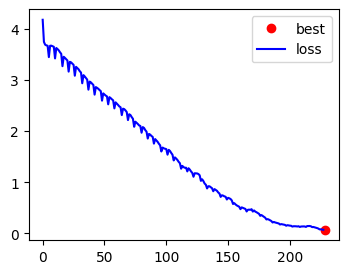

Best epoch so far:  228  smallest loss: 0.0718960140062415
Time taken for the epoch 50.283 sec

Epoch 229 Batch 3 Loss: 0.0500
Epoch 229 Batch 6 Loss: 0.0438
Epoch 229 Batch 9 Loss: 0.1151
Epoch 229 Batch 12 Loss: 0.0655
Epoch 229 Batch 15 Loss: 0.0490
Epoch 229 Batch 18 Loss: 0.0912
Epoch 229 Batch 21 Loss: 0.0542
Epoch 229 Batch 24 Loss: 0.0662

*** Epoch 229 Loss 0.0669 ***

check point saved!
Best epoch so far:  229  smallest loss: 0.06690269449482793
Time taken for the epoch 50.484 sec

Epoch 230 Batch 3 Loss: 0.0496
Epoch 230 Batch 6 Loss: 0.0444
Epoch 230 Batch 9 Loss: 0.1113
Epoch 230 Batch 12 Loss: 0.0563
Epoch 230 Batch 15 Loss: 0.0431
Epoch 230 Batch 18 Loss: 0.0769
Epoch 230 Batch 21 Loss: 0.0536
Epoch 230 Batch 24 Loss: 0.0701

*** Epoch 230 Loss 0.0576 ***

check point saved!
Best epoch so far:  230  smallest loss: 0.05758966052013895
Time taken for the epoch 46.011 sec

Epoch 231 Batch 3 Loss: 0.0508
Epoch 231 Batch 6 Loss: 0.0541
Epoch 231 Batch 9 Loss: 0.0990
Epoch 231

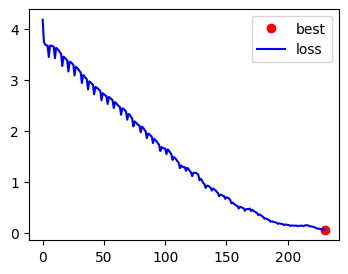

Best epoch so far:  230  smallest loss: 0.05758966052013895
Time taken for the epoch 48.042 sec

Epoch 232 Batch 3 Loss: 0.0496
Epoch 232 Batch 6 Loss: 0.0475
Epoch 232 Batch 9 Loss: 0.0931
Epoch 232 Batch 12 Loss: 0.0646
Epoch 232 Batch 15 Loss: 0.0396
Epoch 232 Batch 18 Loss: 0.0670
Epoch 232 Batch 21 Loss: 0.0352
Epoch 232 Batch 24 Loss: 0.0549

*** Epoch 232 Loss 0.0598 ***

Best epoch so far:  230  smallest loss: 0.05758966052013895
Time taken for the epoch 48.100 sec

Epoch 233 Batch 3 Loss: 0.0392
Epoch 233 Batch 6 Loss: 0.0407
Epoch 233 Batch 9 Loss: 0.1017
Epoch 233 Batch 12 Loss: 0.0537
Epoch 233 Batch 15 Loss: 0.0413
Epoch 233 Batch 18 Loss: 0.0737
Epoch 233 Batch 21 Loss: 0.0390
Epoch 233 Batch 24 Loss: 0.0477

*** Epoch 233 Loss 0.0583 ***

Best epoch so far:  230  smallest loss: 0.05758966052013895
Time taken for the epoch 46.911 sec

Epoch 234 Batch 3 Loss: 0.0392
Epoch 234 Batch 6 Loss: 0.0369
Epoch 234 Batch 9 Loss: 0.0940
Epoch 234 Batch 12 Loss: 0.0517
Epoch 234 Batc

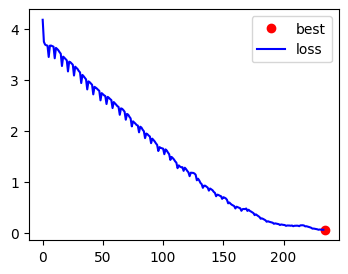

Best epoch so far:  234  smallest loss: 0.057200079378874405
Time taken for the epoch 47.916 sec

Epoch 235 Batch 3 Loss: 0.0421
Epoch 235 Batch 6 Loss: 0.0364
Epoch 235 Batch 9 Loss: 0.0934
Epoch 235 Batch 12 Loss: 0.0461
Epoch 235 Batch 15 Loss: 0.0409
Epoch 235 Batch 18 Loss: 0.0711
Epoch 235 Batch 21 Loss: 0.0465
Epoch 235 Batch 24 Loss: 0.0586

*** Epoch 235 Loss 0.0498 ***

check point saved!
Best epoch so far:  235  smallest loss: 0.049818686817003334
Time taken for the epoch 46.245 sec

Epoch 236 Batch 3 Loss: 0.0429
Epoch 236 Batch 6 Loss: 0.0473
Epoch 236 Batch 9 Loss: 0.0818
Epoch 236 Batch 12 Loss: 0.0618
Epoch 236 Batch 15 Loss: 0.0364
Epoch 236 Batch 18 Loss: 0.0561
Epoch 236 Batch 21 Loss: 0.0327
Epoch 236 Batch 24 Loss: 0.0561

*** Epoch 236 Loss 0.0545 ***

Best epoch so far:  235  smallest loss: 0.049818686817003334
Time taken for the epoch 46.687 sec

Epoch 237 Batch 3 Loss: 0.0447
Epoch 237 Batch 6 Loss: 0.0442
Epoch 237 Batch 9 Loss: 0.0852
Epoch 237 Batch 12 Loss:

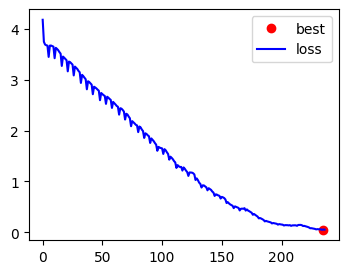

Best epoch so far:  235  smallest loss: 0.049818686817003334
Time taken for the epoch 47.280 sec

Epoch 238 Batch 3 Loss: 0.0425
Epoch 238 Batch 6 Loss: 0.0405
Epoch 238 Batch 9 Loss: 0.0902
Epoch 238 Batch 12 Loss: 0.0514
Epoch 238 Batch 15 Loss: 0.0373
Epoch 238 Batch 18 Loss: 0.0637
Epoch 238 Batch 21 Loss: 0.0329
Epoch 238 Batch 24 Loss: 0.0420

*** Epoch 238 Loss 0.0518 ***

Best epoch so far:  235  smallest loss: 0.049818686817003334
Time taken for the epoch 47.258 sec

Epoch 239 Batch 3 Loss: 0.0345
Epoch 239 Batch 6 Loss: 0.0351
Epoch 239 Batch 9 Loss: 0.0775
Epoch 239 Batch 12 Loss: 0.0453
Epoch 239 Batch 15 Loss: 0.0356
Epoch 239 Batch 18 Loss: 0.0638
Epoch 239 Batch 21 Loss: 0.0389
Epoch 239 Batch 24 Loss: 0.0465

*** Epoch 239 Loss 0.0512 ***

Best epoch so far:  235  smallest loss: 0.049818686817003334
Time taken for the epoch 47.834 sec

Epoch 240 Batch 3 Loss: 0.0363
Epoch 240 Batch 6 Loss: 0.0337
Epoch 240 Batch 9 Loss: 0.0863
Epoch 240 Batch 12 Loss: 0.0436
Epoch 240 B

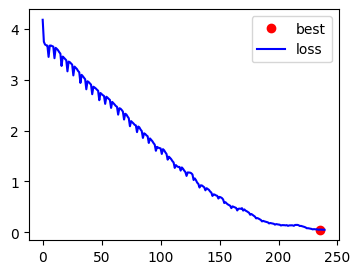

Best epoch so far:  235  smallest loss: 0.049818686817003334
Time taken for the epoch 47.690 sec

Epoch 241 Batch 3 Loss: 0.0347
Epoch 241 Batch 6 Loss: 0.0360
Epoch 241 Batch 9 Loss: 0.0747
Epoch 241 Batch 12 Loss: 0.0422
Epoch 241 Batch 15 Loss: 0.0339
Epoch 241 Batch 18 Loss: 0.0597
Epoch 241 Batch 21 Loss: 0.0397
Epoch 241 Batch 24 Loss: 0.0672

*** Epoch 241 Loss 0.0439 ***

check point saved!
Best epoch so far:  241  smallest loss: 0.043871672257133155
Time taken for the epoch 45.719 sec

Epoch 242 Batch 3 Loss: 0.0423
Epoch 242 Batch 6 Loss: 0.0420
Epoch 242 Batch 9 Loss: 0.0776
Epoch 242 Batch 12 Loss: 0.0540
Epoch 242 Batch 15 Loss: 0.0348
Epoch 242 Batch 18 Loss: 0.0496
Epoch 242 Batch 21 Loss: 0.0234
Epoch 242 Batch 24 Loss: 0.0414

*** Epoch 242 Loss 0.0476 ***

Best epoch so far:  241  smallest loss: 0.043871672257133155
Time taken for the epoch 47.513 sec

Epoch 243 Batch 3 Loss: 0.0407
Epoch 243 Batch 6 Loss: 0.0375
Epoch 243 Batch 9 Loss: 0.0790
Epoch 243 Batch 12 Loss:

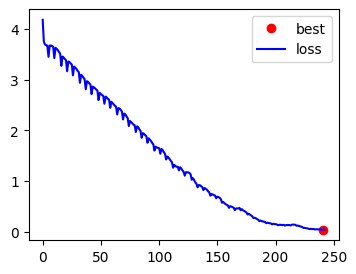

Best epoch so far:  241  smallest loss: 0.043871672257133155
Time taken for the epoch 46.888 sec

Epoch 244 Batch 3 Loss: 0.0301
Epoch 244 Batch 6 Loss: 0.0308
Epoch 244 Batch 9 Loss: 0.0861
Epoch 244 Batch 12 Loss: 0.0436
Epoch 244 Batch 15 Loss: 0.0337
Epoch 244 Batch 18 Loss: 0.0564
Epoch 244 Batch 21 Loss: 0.0332
Epoch 244 Batch 24 Loss: 0.0402

*** Epoch 244 Loss 0.0475 ***

Best epoch so far:  241  smallest loss: 0.043871672257133155
Time taken for the epoch 47.951 sec

Epoch 245 Batch 3 Loss: 0.0332
Epoch 245 Batch 6 Loss: 0.0310
Epoch 245 Batch 9 Loss: 0.0809
Epoch 245 Batch 12 Loss: 0.0422
Epoch 245 Batch 15 Loss: 0.0350
Epoch 245 Batch 18 Loss: 0.0650
Epoch 245 Batch 21 Loss: 0.0363
Epoch 245 Batch 24 Loss: 0.0442

*** Epoch 245 Loss 0.0459 ***

Best epoch so far:  241  smallest loss: 0.043871672257133155
Time taken for the epoch 47.999 sec

Epoch 246 Batch 3 Loss: 0.0340
Epoch 246 Batch 6 Loss: 0.0321
Epoch 246 Batch 9 Loss: 0.0837
Epoch 246 Batch 12 Loss: 0.0366
Epoch 246 B

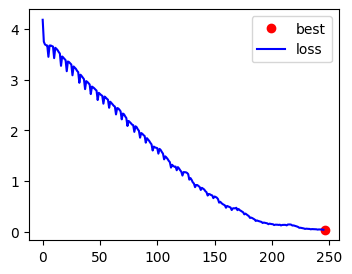

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 46.084 sec

Epoch 247 Batch 3 Loss: 0.0404
Epoch 247 Batch 6 Loss: 0.0409
Epoch 247 Batch 9 Loss: 0.0806
Epoch 247 Batch 12 Loss: 0.0516
Epoch 247 Batch 15 Loss: 0.0300
Epoch 247 Batch 18 Loss: 0.0443
Epoch 247 Batch 21 Loss: 0.0203
Epoch 247 Batch 24 Loss: 0.0470

*** Epoch 247 Loss 0.0473 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 46.654 sec

Epoch 248 Batch 3 Loss: 0.0396
Epoch 248 Batch 6 Loss: 0.0404
Epoch 248 Batch 9 Loss: 0.1178
Epoch 248 Batch 12 Loss: 0.0502
Epoch 248 Batch 15 Loss: 0.0333
Epoch 248 Batch 18 Loss: 0.0513
Epoch 248 Batch 21 Loss: 0.0248
Epoch 248 Batch 24 Loss: 0.0451

*** Epoch 248 Loss 0.0503 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.165 sec

Epoch 249 Batch 3 Loss: 0.0307
Epoch 249 Batch 6 Loss: 0.0320
Epoch 249 Batch 9 Loss: 0.1276
Epoch 249 Batch 12 Loss: 0.0406
Epoch 249 B

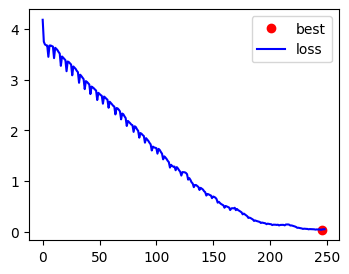

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.254 sec

Epoch 250 Batch 3 Loss: 0.0312
Epoch 250 Batch 6 Loss: 0.0310
Epoch 250 Batch 9 Loss: 0.1355
Epoch 250 Batch 12 Loss: 0.0410
Epoch 250 Batch 15 Loss: 0.0375
Epoch 250 Batch 18 Loss: 0.0674
Epoch 250 Batch 21 Loss: 0.0361
Epoch 250 Batch 24 Loss: 0.0495

*** Epoch 250 Loss 0.0533 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.179 sec

Epoch 251 Batch 3 Loss: 0.0339
Epoch 251 Batch 6 Loss: 0.0312
Epoch 251 Batch 9 Loss: 0.1727
Epoch 251 Batch 12 Loss: 0.0392
Epoch 251 Batch 15 Loss: 0.0359
Epoch 251 Batch 18 Loss: 0.0668
Epoch 251 Batch 21 Loss: 0.0458
Epoch 251 Batch 24 Loss: 0.0545

*** Epoch 251 Loss 0.0499 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 45.056 sec

Epoch 252 Batch 3 Loss: 0.0372
Epoch 252 Batch 6 Loss: 0.0426
Epoch 252 Batch 9 Loss: 0.0961
Epoch 252 Batch 12 Loss: 0.0584
Epoch 252 B

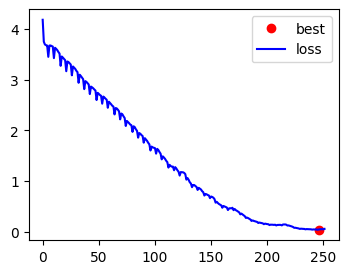

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 47.582 sec

Epoch 253 Batch 3 Loss: 0.0393
Epoch 253 Batch 6 Loss: 0.0385
Epoch 253 Batch 9 Loss: 0.1205
Epoch 253 Batch 12 Loss: 0.0634
Epoch 253 Batch 15 Loss: 0.0381
Epoch 253 Batch 18 Loss: 0.0596
Epoch 253 Batch 21 Loss: 0.0313
Epoch 253 Batch 24 Loss: 0.0500

*** Epoch 253 Loss 0.0609 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 47.688 sec

Epoch 254 Batch 3 Loss: 0.0403
Epoch 254 Batch 6 Loss: 0.0367
Epoch 254 Batch 9 Loss: 0.1713
Epoch 254 Batch 12 Loss: 0.0581
Epoch 254 Batch 15 Loss: 0.0421
Epoch 254 Batch 18 Loss: 0.0949
Epoch 254 Batch 21 Loss: 0.0395
Epoch 254 Batch 24 Loss: 0.0466

*** Epoch 254 Loss 0.0677 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.572 sec

Epoch 255 Batch 3 Loss: 0.0501
Epoch 255 Batch 6 Loss: 0.0388
Epoch 255 Batch 9 Loss: 0.2150
Epoch 255 Batch 12 Loss: 0.0533
Epoch 255 B

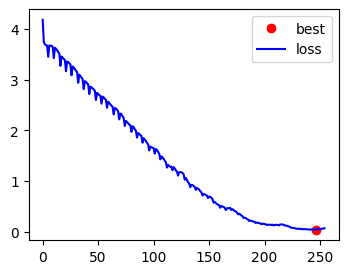

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.184 sec

Epoch 256 Batch 3 Loss: 0.0461
Epoch 256 Batch 6 Loss: 0.0369
Epoch 256 Batch 9 Loss: 0.2279
Epoch 256 Batch 12 Loss: 0.0527
Epoch 256 Batch 15 Loss: 0.0503
Epoch 256 Batch 18 Loss: 0.0845
Epoch 256 Batch 21 Loss: 0.0506
Epoch 256 Batch 24 Loss: 0.0640

*** Epoch 256 Loss 0.0703 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 46.830 sec

Epoch 257 Batch 3 Loss: 0.0391
Epoch 257 Batch 6 Loss: 0.0365
Epoch 257 Batch 9 Loss: 0.1874
Epoch 257 Batch 12 Loss: 0.0529
Epoch 257 Batch 15 Loss: 0.0418
Epoch 257 Batch 18 Loss: 0.0718
Epoch 257 Batch 21 Loss: 0.0451
Epoch 257 Batch 24 Loss: 0.0779

*** Epoch 257 Loss 0.0616 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 44.877 sec

Epoch 258 Batch 3 Loss: 0.0472
Epoch 258 Batch 6 Loss: 0.0451
Epoch 258 Batch 9 Loss: 0.1329
Epoch 258 Batch 12 Loss: 0.0676
Epoch 258 B

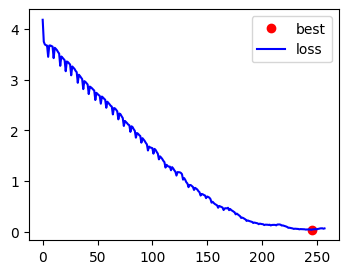

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.046 sec

Epoch 259 Batch 3 Loss: 0.0404
Epoch 259 Batch 6 Loss: 0.0419
Epoch 259 Batch 9 Loss: 0.1590
Epoch 259 Batch 12 Loss: 0.0571
Epoch 259 Batch 15 Loss: 0.0488
Epoch 259 Batch 18 Loss: 0.0695
Epoch 259 Batch 21 Loss: 0.0336
Epoch 259 Batch 24 Loss: 0.0505

*** Epoch 259 Loss 0.0654 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 47.058 sec

Epoch 260 Batch 3 Loss: 0.0349
Epoch 260 Batch 6 Loss: 0.0320
Epoch 260 Batch 9 Loss: 0.1437
Epoch 260 Batch 12 Loss: 0.0460
Epoch 260 Batch 15 Loss: 0.0435
Epoch 260 Batch 18 Loss: 0.0684
Epoch 260 Batch 21 Loss: 0.0407
Epoch 260 Batch 24 Loss: 0.0464

*** Epoch 260 Loss 0.0599 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 46.920 sec

Epoch 261 Batch 3 Loss: 0.0396
Epoch 261 Batch 6 Loss: 0.0299
Epoch 261 Batch 9 Loss: 0.1318
Epoch 261 Batch 12 Loss: 0.0473
Epoch 261 B

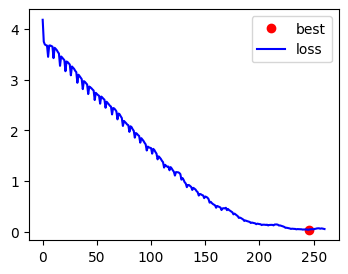

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 48.056 sec

Epoch 262 Batch 3 Loss: 0.0361
Epoch 262 Batch 6 Loss: 0.0312
Epoch 262 Batch 9 Loss: 0.1115
Epoch 262 Batch 12 Loss: 0.0379
Epoch 262 Batch 15 Loss: 0.0302
Epoch 262 Batch 18 Loss: 0.0539
Epoch 262 Batch 21 Loss: 0.0408
Epoch 262 Batch 24 Loss: 0.0528

*** Epoch 262 Loss 0.0450 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 44.812 sec

Epoch 263 Batch 3 Loss: 0.0379
Epoch 263 Batch 6 Loss: 0.0374
Epoch 263 Batch 9 Loss: 0.0942
Epoch 263 Batch 12 Loss: 0.0508
Epoch 263 Batch 15 Loss: 0.0303
Epoch 263 Batch 18 Loss: 0.0444
Epoch 263 Batch 21 Loss: 0.0182
Epoch 263 Batch 24 Loss: 0.0427

*** Epoch 263 Loss 0.0464 ***

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 47.121 sec

Epoch 264 Batch 3 Loss: 0.0361
Epoch 264 Batch 6 Loss: 0.0327
Epoch 264 Batch 9 Loss: 0.0863
Epoch 264 Batch 12 Loss: 0.0415
Epoch 264 B

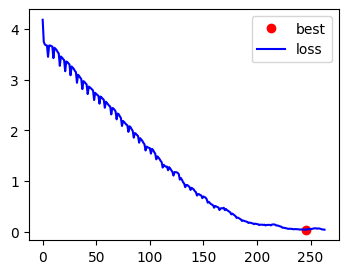

Best epoch so far:  246  smallest loss: 0.040758366170136826
Time taken for the epoch 46.788 sec

Epoch 265 Batch 3 Loss: 0.0261
Epoch 265 Batch 6 Loss: 0.0271
Epoch 265 Batch 9 Loss: 0.0844
Epoch 265 Batch 12 Loss: 0.0356
Epoch 265 Batch 15 Loss: 0.0286
Epoch 265 Batch 18 Loss: 0.0493
Epoch 265 Batch 21 Loss: 0.0231
Epoch 265 Batch 24 Loss: 0.0303

*** Epoch 265 Loss 0.0402 ***

check point saved!
Best epoch so far:  265  smallest loss: 0.04020953178405762
Time taken for the epoch 47.489 sec

Epoch 266 Batch 3 Loss: 0.0259
Epoch 266 Batch 6 Loss: 0.0262
Epoch 266 Batch 9 Loss: 0.0727
Epoch 266 Batch 12 Loss: 0.0309
Epoch 266 Batch 15 Loss: 0.0299
Epoch 266 Batch 18 Loss: 0.0569
Epoch 266 Batch 21 Loss: 0.0272
Epoch 266 Batch 24 Loss: 0.0595

*** Epoch 266 Loss 0.0403 ***

Best epoch so far:  265  smallest loss: 0.04020953178405762
Time taken for the epoch 47.996 sec

Epoch 267 Batch 3 Loss: 0.0266
Epoch 267 Batch 6 Loss: 0.0256
Epoch 267 Batch 9 Loss: 0.0695
Epoch 267 Batch 12 Loss: 0

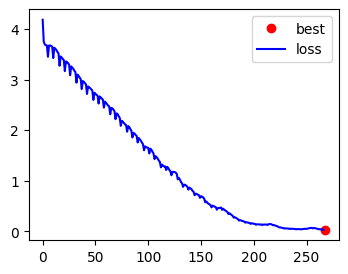

Best epoch so far:  267  smallest loss: 0.03367405870686407
Time taken for the epoch 44.582 sec

Epoch 268 Batch 3 Loss: 0.0275
Epoch 268 Batch 6 Loss: 0.0350
Epoch 268 Batch 9 Loss: 0.0559
Epoch 268 Batch 12 Loss: 0.0367
Epoch 268 Batch 15 Loss: 0.0233
Epoch 268 Batch 18 Loss: 0.0330
Epoch 268 Batch 21 Loss: 0.0210
Epoch 268 Batch 24 Loss: 0.0423

*** Epoch 268 Loss 0.0351 ***

Best epoch so far:  267  smallest loss: 0.03367405870686407
Time taken for the epoch 47.343 sec

Epoch 269 Batch 3 Loss: 0.0277
Epoch 269 Batch 6 Loss: 0.0326
Epoch 269 Batch 9 Loss: 0.0590
Epoch 269 Batch 12 Loss: 0.0341
Epoch 269 Batch 15 Loss: 0.0264
Epoch 269 Batch 18 Loss: 0.0292
Epoch 269 Batch 21 Loss: 0.0175
Epoch 269 Batch 24 Loss: 0.0290

*** Epoch 269 Loss 0.0332 ***

check point saved!
Best epoch so far:  269  smallest loss: 0.033210020998249885
Time taken for the epoch 49.553 sec

Epoch 270 Batch 3 Loss: 0.0266
Epoch 270 Batch 6 Loss: 0.0243
Epoch 270 Batch 9 Loss: 0.0642
Epoch 270 Batch 12 Loss: 0

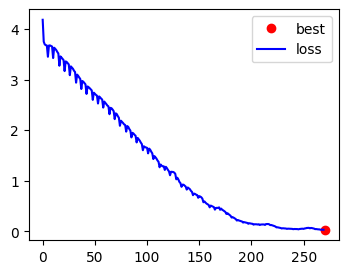

Best epoch so far:  270  smallest loss: 0.03208426807237708
Time taken for the epoch 48.481 sec

Epoch 271 Batch 3 Loss: 0.0206
Epoch 271 Batch 6 Loss: 0.0212
Epoch 271 Batch 9 Loss: 0.0537
Epoch 271 Batch 12 Loss: 0.0255
Epoch 271 Batch 15 Loss: 0.0236
Epoch 271 Batch 18 Loss: 0.0386
Epoch 271 Batch 21 Loss: 0.0210
Epoch 271 Batch 24 Loss: 0.0270

*** Epoch 271 Loss 0.0313 ***

check point saved!
Best epoch so far:  271  smallest loss: 0.03133821487426758
Time taken for the epoch 47.331 sec

Epoch 272 Batch 3 Loss: 0.0213
Epoch 272 Batch 6 Loss: 0.0206
Epoch 272 Batch 9 Loss: 0.0588
Epoch 272 Batch 12 Loss: 0.0232
Epoch 272 Batch 15 Loss: 0.0220
Epoch 272 Batch 18 Loss: 0.0414
Epoch 272 Batch 21 Loss: 0.0235
Epoch 272 Batch 24 Loss: 0.0298

*** Epoch 272 Loss 0.0299 ***

check point saved!
Best epoch so far:  272  smallest loss: 0.02987056711445684
Time taken for the epoch 46.836 sec

Epoch 273 Batch 3 Loss: 0.0197
Epoch 273 Batch 6 Loss: 0.0215
Epoch 273 Batch 9 Loss: 0.0473
Epoch 27

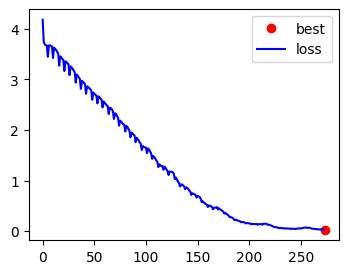

Best epoch so far:  273  smallest loss: 0.02601423989171567
Time taken for the epoch 45.131 sec

Epoch 274 Batch 3 Loss: 0.0249
Epoch 274 Batch 6 Loss: 0.0249
Epoch 274 Batch 9 Loss: 0.0502
Epoch 274 Batch 12 Loss: 0.0305
Epoch 274 Batch 15 Loss: 0.0203
Epoch 274 Batch 18 Loss: 0.0256
Epoch 274 Batch 21 Loss: 0.0125
Epoch 274 Batch 24 Loss: 0.0229

*** Epoch 274 Loss 0.0279 ***

Best epoch so far:  273  smallest loss: 0.02601423989171567
Time taken for the epoch 47.560 sec

Epoch 275 Batch 3 Loss: 0.0230
Epoch 275 Batch 6 Loss: 0.0219
Epoch 275 Batch 9 Loss: 0.0512
Epoch 275 Batch 12 Loss: 0.0275
Epoch 275 Batch 15 Loss: 0.0204
Epoch 275 Batch 18 Loss: 0.0308
Epoch 275 Batch 21 Loss: 0.0150
Epoch 275 Batch 24 Loss: 0.0234

*** Epoch 275 Loss 0.0275 ***

Best epoch so far:  273  smallest loss: 0.02601423989171567
Time taken for the epoch 48.027 sec

Epoch 276 Batch 3 Loss: 0.0179
Epoch 276 Batch 6 Loss: 0.0176
Epoch 276 Batch 9 Loss: 0.0553
Epoch 276 Batch 12 Loss: 0.0228
Epoch 276 Batc

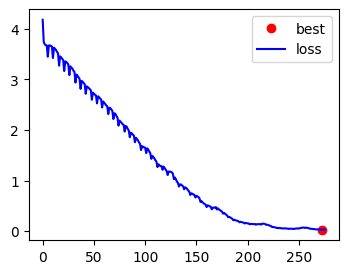

Best epoch so far:  273  smallest loss: 0.02601423989171567
Time taken for the epoch 48.823 sec

Epoch 277 Batch 3 Loss: 0.0206
Epoch 277 Batch 6 Loss: 0.0185
Epoch 277 Batch 9 Loss: 0.0547
Epoch 277 Batch 12 Loss: 0.0244
Epoch 277 Batch 15 Loss: 0.0222
Epoch 277 Batch 18 Loss: 0.0398
Epoch 277 Batch 21 Loss: 0.0215
Epoch 277 Batch 24 Loss: 0.0261

*** Epoch 277 Loss 0.0291 ***

Best epoch so far:  273  smallest loss: 0.02601423989171567
Time taken for the epoch 48.168 sec

Epoch 278 Batch 3 Loss: 0.0203
Epoch 278 Batch 6 Loss: 0.0194
Epoch 278 Batch 9 Loss: 0.0539
Epoch 278 Batch 12 Loss: 0.0202
Epoch 278 Batch 15 Loss: 0.0196
Epoch 278 Batch 18 Loss: 0.0352
Epoch 278 Batch 21 Loss: 0.0214
Epoch 278 Batch 24 Loss: 0.0276

*** Epoch 278 Loss 0.0249 ***

check point saved!
Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 44.904 sec

Epoch 279 Batch 3 Loss: 0.0232
Epoch 279 Batch 6 Loss: 0.0235
Epoch 279 Batch 9 Loss: 0.0594
Epoch 279 Batch 12 Loss: 0.

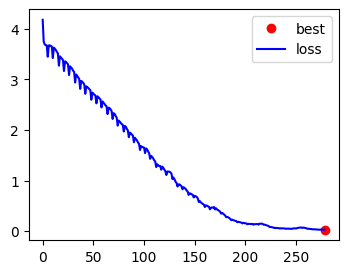

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 46.775 sec

Epoch 280 Batch 3 Loss: 0.0227
Epoch 280 Batch 6 Loss: 0.0211
Epoch 280 Batch 9 Loss: 0.0593
Epoch 280 Batch 12 Loss: 0.0276
Epoch 280 Batch 15 Loss: 0.0186
Epoch 280 Batch 18 Loss: 0.0284
Epoch 280 Batch 21 Loss: 0.0149
Epoch 280 Batch 24 Loss: 0.0227

*** Epoch 280 Loss 0.0273 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.471 sec

Epoch 281 Batch 3 Loss: 0.0176
Epoch 281 Batch 6 Loss: 0.0180
Epoch 281 Batch 9 Loss: 0.0659
Epoch 281 Batch 12 Loss: 0.0267
Epoch 281 Batch 15 Loss: 0.0192
Epoch 281 Batch 18 Loss: 0.0360
Epoch 281 Batch 21 Loss: 0.0170
Epoch 281 Batch 24 Loss: 0.0211

*** Epoch 281 Loss 0.0282 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 50.818 sec

Epoch 282 Batch 3 Loss: 0.0185
Epoch 282 Batch 6 Loss: 0.0173
Epoch 282 Batch 9 Loss: 0.0614
Epoch 282 Batch 12 Loss: 0.0229
Epoch 282 Batc

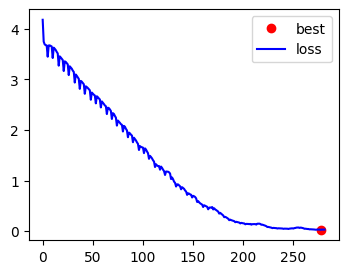

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 50.483 sec

Epoch 283 Batch 3 Loss: 0.0203
Epoch 283 Batch 6 Loss: 0.0175
Epoch 283 Batch 9 Loss: 0.0685
Epoch 283 Batch 12 Loss: 0.0193
Epoch 283 Batch 15 Loss: 0.0191
Epoch 283 Batch 18 Loss: 0.0374
Epoch 283 Batch 21 Loss: 0.0199
Epoch 283 Batch 24 Loss: 0.0265

*** Epoch 283 Loss 0.0252 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 47.219 sec

Epoch 284 Batch 3 Loss: 0.0211
Epoch 284 Batch 6 Loss: 0.0222
Epoch 284 Batch 9 Loss: 0.0446
Epoch 284 Batch 12 Loss: 0.0377
Epoch 284 Batch 15 Loss: 0.0182
Epoch 284 Batch 18 Loss: 0.0252
Epoch 284 Batch 21 Loss: 0.0180
Epoch 284 Batch 24 Loss: 0.0273

*** Epoch 284 Loss 0.0312 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.506 sec

Epoch 285 Batch 3 Loss: 0.0224
Epoch 285 Batch 6 Loss: 0.0239
Epoch 285 Batch 9 Loss: 0.0510
Epoch 285 Batch 12 Loss: 0.0345
Epoch 285 Batc

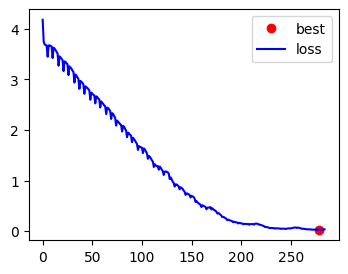

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 50.313 sec

Epoch 286 Batch 3 Loss: 0.0228
Epoch 286 Batch 6 Loss: 0.0221
Epoch 286 Batch 9 Loss: 0.0817
Epoch 286 Batch 12 Loss: 0.0302
Epoch 286 Batch 15 Loss: 0.0251
Epoch 286 Batch 18 Loss: 0.0445
Epoch 286 Batch 21 Loss: 0.0179
Epoch 286 Batch 24 Loss: 0.0296

*** Epoch 286 Loss 0.0361 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 48.650 sec

Epoch 287 Batch 3 Loss: 0.0230
Epoch 287 Batch 6 Loss: 0.0304
Epoch 287 Batch 9 Loss: 0.0918
Epoch 287 Batch 12 Loss: 0.0289
Epoch 287 Batch 15 Loss: 0.0300
Epoch 287 Batch 18 Loss: 0.0631
Epoch 287 Batch 21 Loss: 0.0328
Epoch 287 Batch 24 Loss: 0.0352

*** Epoch 287 Loss 0.0450 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.031 sec

Epoch 288 Batch 3 Loss: 0.0294
Epoch 288 Batch 6 Loss: 0.0368
Epoch 288 Batch 9 Loss: 0.1309
Epoch 288 Batch 12 Loss: 0.0309
Epoch 288 Batc

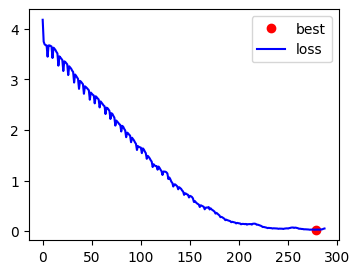

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.431 sec

Epoch 289 Batch 3 Loss: 0.0337
Epoch 289 Batch 6 Loss: 0.0428
Epoch 289 Batch 9 Loss: 0.1021
Epoch 289 Batch 12 Loss: 0.0348
Epoch 289 Batch 15 Loss: 0.0286
Epoch 289 Batch 18 Loss: 0.0712
Epoch 289 Batch 21 Loss: 0.0454
Epoch 289 Batch 24 Loss: 0.0666

*** Epoch 289 Loss 0.0455 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 46.562 sec

Epoch 290 Batch 3 Loss: 0.0345
Epoch 290 Batch 6 Loss: 0.0464
Epoch 290 Batch 9 Loss: 0.0807
Epoch 290 Batch 12 Loss: 0.0508
Epoch 290 Batch 15 Loss: 0.0475
Epoch 290 Batch 18 Loss: 0.0426
Epoch 290 Batch 21 Loss: 0.0200
Epoch 290 Batch 24 Loss: 0.0499

*** Epoch 290 Loss 0.0518 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.475 sec

Epoch 291 Batch 3 Loss: 0.0331
Epoch 291 Batch 6 Loss: 0.0536
Epoch 291 Batch 9 Loss: 0.0828
Epoch 291 Batch 12 Loss: 0.0422
Epoch 291 Batc

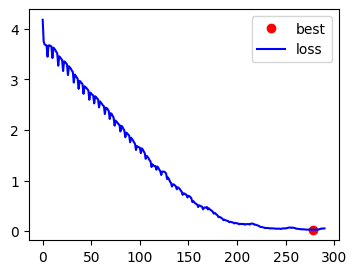

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.535 sec

Epoch 292 Batch 3 Loss: 0.0294
Epoch 292 Batch 6 Loss: 0.0333
Epoch 292 Batch 9 Loss: 0.0998
Epoch 292 Batch 12 Loss: 0.0362
Epoch 292 Batch 15 Loss: 0.0644
Epoch 292 Batch 18 Loss: 0.0645
Epoch 292 Batch 21 Loss: 0.0360
Epoch 292 Batch 24 Loss: 0.0717

*** Epoch 292 Loss 0.0527 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 50.447 sec

Epoch 293 Batch 3 Loss: 0.0348
Epoch 293 Batch 6 Loss: 0.0300
Epoch 293 Batch 9 Loss: 0.1197
Epoch 293 Batch 12 Loss: 0.0446
Epoch 293 Batch 15 Loss: 0.0814
Epoch 293 Batch 18 Loss: 0.0752
Epoch 293 Batch 21 Loss: 0.0516
Epoch 293 Batch 24 Loss: 0.0688

*** Epoch 293 Loss 0.0586 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 48.671 sec

Epoch 294 Batch 3 Loss: 0.0442
Epoch 294 Batch 6 Loss: 0.0546
Epoch 294 Batch 9 Loss: 0.1250
Epoch 294 Batch 12 Loss: 0.0721
Epoch 294 Batc

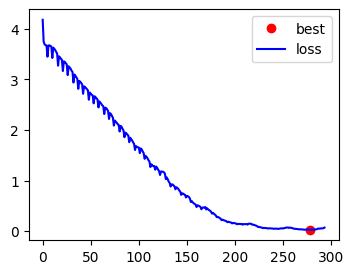

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 47.725 sec

Epoch 295 Batch 3 Loss: 0.1065
Epoch 295 Batch 6 Loss: 0.0701
Epoch 295 Batch 9 Loss: 0.1051
Epoch 295 Batch 12 Loss: 0.1470
Epoch 295 Batch 15 Loss: 0.0444
Epoch 295 Batch 18 Loss: 0.0971
Epoch 295 Batch 21 Loss: 0.0307
Epoch 295 Batch 24 Loss: 0.0756

*** Epoch 295 Loss 0.0800 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.157 sec

Epoch 296 Batch 3 Loss: 0.0781
Epoch 296 Batch 6 Loss: 0.0564
Epoch 296 Batch 9 Loss: 0.0991
Epoch 296 Batch 12 Loss: 0.0928
Epoch 296 Batch 15 Loss: 0.0436
Epoch 296 Batch 18 Loss: 0.0866
Epoch 296 Batch 21 Loss: 0.0296
Epoch 296 Batch 24 Loss: 0.0542

*** Epoch 296 Loss 0.0694 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 50.373 sec

Epoch 297 Batch 3 Loss: 0.0336
Epoch 297 Batch 6 Loss: 0.0519
Epoch 297 Batch 9 Loss: 0.1221
Epoch 297 Batch 12 Loss: 0.0592
Epoch 297 Batc

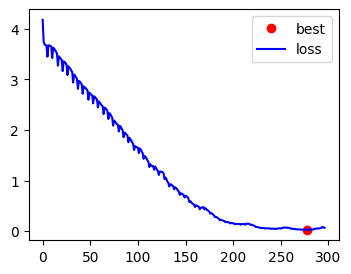

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 48.896 sec

Epoch 298 Batch 3 Loss: 0.0441
Epoch 298 Batch 6 Loss: 0.0398
Epoch 298 Batch 9 Loss: 0.0975
Epoch 298 Batch 12 Loss: 0.0513
Epoch 298 Batch 15 Loss: 0.0403
Epoch 298 Batch 18 Loss: 0.0791
Epoch 298 Batch 21 Loss: 0.0401
Epoch 298 Batch 24 Loss: 0.0566

*** Epoch 298 Loss 0.0585 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 50.691 sec

Epoch 299 Batch 3 Loss: 0.0427
Epoch 299 Batch 6 Loss: 0.0292
Epoch 299 Batch 9 Loss: 0.0991
Epoch 299 Batch 12 Loss: 0.0456
Epoch 299 Batch 15 Loss: 0.0404
Epoch 299 Batch 18 Loss: 0.0696
Epoch 299 Batch 21 Loss: 0.0388
Epoch 299 Batch 24 Loss: 0.0566

*** Epoch 299 Loss 0.0489 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 48.482 sec

Epoch 300 Batch 3 Loss: 0.0410
Epoch 300 Batch 6 Loss: 0.0530
Epoch 300 Batch 9 Loss: 0.0810
Epoch 300 Batch 12 Loss: 0.0568
Epoch 300 Batc

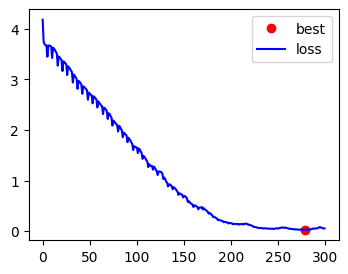

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.966 sec

Epoch 301 Batch 3 Loss: 0.0408
Epoch 301 Batch 6 Loss: 0.0420
Epoch 301 Batch 9 Loss: 0.0791
Epoch 301 Batch 12 Loss: 0.0510
Epoch 301 Batch 15 Loss: 0.0257
Epoch 301 Batch 18 Loss: 0.0418
Epoch 301 Batch 21 Loss: 0.0379
Epoch 301 Batch 24 Loss: 0.0480

*** Epoch 301 Loss 0.0467 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.047 sec

Epoch 302 Batch 3 Loss: 0.0365
Epoch 302 Batch 6 Loss: 0.0334
Epoch 302 Batch 9 Loss: 0.0871
Epoch 302 Batch 12 Loss: 0.0526
Epoch 302 Batch 15 Loss: 0.0282
Epoch 302 Batch 18 Loss: 0.0551
Epoch 302 Batch 21 Loss: 0.0310
Epoch 302 Batch 24 Loss: 0.0401

*** Epoch 302 Loss 0.0472 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.295 sec

Epoch 303 Batch 3 Loss: 0.0319
Epoch 303 Batch 6 Loss: 0.0261
Epoch 303 Batch 9 Loss: 0.0760
Epoch 303 Batch 12 Loss: 0.0393
Epoch 303 Batc

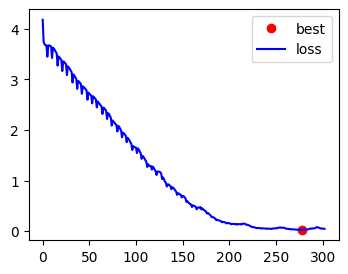

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.386 sec

Epoch 304 Batch 3 Loss: 0.0298
Epoch 304 Batch 6 Loss: 0.0285
Epoch 304 Batch 9 Loss: 0.0720
Epoch 304 Batch 12 Loss: 0.0285
Epoch 304 Batch 15 Loss: 0.0253
Epoch 304 Batch 18 Loss: 0.0570
Epoch 304 Batch 21 Loss: 0.0328
Epoch 304 Batch 24 Loss: 0.0364

*** Epoch 304 Loss 0.0400 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 49.283 sec

Epoch 305 Batch 3 Loss: 0.0232
Epoch 305 Batch 6 Loss: 0.0254
Epoch 305 Batch 9 Loss: 0.0606
Epoch 305 Batch 12 Loss: 0.0324
Epoch 305 Batch 15 Loss: 0.0213
Epoch 305 Batch 18 Loss: 0.0415
Epoch 305 Batch 21 Loss: 0.0260
Epoch 305 Batch 24 Loss: 0.0443

*** Epoch 305 Loss 0.0330 ***

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 47.613 sec

Epoch 306 Batch 3 Loss: 0.0299
Epoch 306 Batch 6 Loss: 0.0295
Epoch 306 Batch 9 Loss: 0.0473
Epoch 306 Batch 12 Loss: 0.0419
Epoch 306 Batc

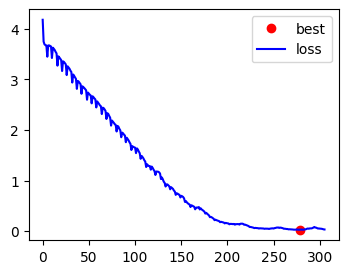

Best epoch so far:  278  smallest loss: 0.02493300904398379
Time taken for the epoch 48.894 sec



In [36]:
batch_loss = K.constant(0)
X, y = [], []
for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 3 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep,' smallest loss:',smallest_loss)
    print('Time taken for the epoch {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)   

## Результат

Я обучал 306 эпох, но как видно из графика функция потери достигла плато около 200 эпохи и далее продолжать обучение было довольно бессмысленно. Как видно несмотря на относительно маленькое для таких задачь количество входных данных удалось создать вполне функционального чатбота, который действительно отвечает в духе отыгрыша нашего выбранного персонажа.

In [37]:
checkpoint.restore(snapshot_folder+'/'+str(emb_dim)+"-ckpt-278") 

In [72]:
answer("what is your name")

Ввод: what is your name
Предсазанный ответ: celestia eyes widen in the room and then nods her tone is there a connection like bit up at the pony kingdom 


In [73]:
answer("i run into the room and say there is an situation demanding your attention")

Ввод: i run into the room and say there is an situation demanding your attention
Предсазанный ответ: celestia stops with a moment of a walk or is there in order and the right thing i do know of the ponies or not too much a human males 


In [74]:
answer("i raise my sword and swear to be loyal to Celestia")

Ввод: i raise my sword and swear to be loyal to celestia
Предсазанный ответ: yes my subjects and 
